<a href="https://colab.research.google.com/github/Berigny/AI-Entrainment-Protocol/blob/main/LENR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Energy Nuclear (LENR) Cycles Model
This notebook tests whether a minimal, topology-first model can simulate and falsify a low-energy nuclear reaction (LENR) cycle driven by breath-like EM coherence. Using Discrete Exterior Calculus (DEC) on a star-tetrahedral complex with a shared centroid, we evolve fields, enforce first-law energy accounting, monitor entropy production and phase relations, and—optionally—add an adelic (ℝ × ℚ_p) layer to represent hierarchical memory at the fusion node. If quantised heat bursts do not emerge with lawful topology, pre-burst EM signatures, rising EPR, and correct energy balance, the hypothesis is weakened. If they do, we proceed to richer modelling and lab validation. The prize is significant: a path to low-cost, high-yield, sustainable energy in an energy-hungry world.

## Falsification criteria

We consider the LENR cycle unsupported if any lawful configuration fails to produce:
(i) pre-burst EM coherence with ~90° E–M phase and centroid mediation,
(ii) quantised heat steps at the sink,
(iii) a non-negative EPR that rises prior to bursts, and
(iv) first-law integrity (residual ≈ 0).
Controls must behave as expected: illegal shortcuts reduce irreversibility or break energy accounting; removing C→3 or 1→2 kills bursts; random primes revert to baseline.

## Notebook Overview & Research Aim
### Goal
- Simulate and *attempt to falsify* LENR-like cycles on a tetrahedral (and star-tetrahedral) topology.
- If not falsified, motivate deeper modelling and lab tests for low-cost, high-yield, sustainable energy.
### Key Ideas
- DEC on simplicial complexes; mediation via centroid **C**; breath-driven, asymmetric flows; adelic (ℝ×ℚ_p) layer.

In [1]:

# @title 0. **Config — toggles & seeds** { display-mode: "form" }
# @markdown Core switches used by downstream cells.

# pyright: reportMissingImports=false, reportMissingModuleSource=false, reportUndefinedVariable=false
# Static-analysis stubs; real values are set later during execution.
try:
    import mpmath  # type: ignore
    import sympy  # type: ignore
except Exception:
    pass
globals().setdefault('global_dt', 0.0)
globals().setdefault('global_epsilon', 1.0)
globals().setdefault('global_mu', 1.0)
globals().setdefault('global_sigma', 0.0)
globals().setdefault('n_edges', 0)
globals().setdefault('n_faces', 0)
globals().setdefault('edge_idx', {})
globals().setdefault('phi_star', None)
globals().setdefault('linter_fn', None)
globals().setdefault('pe', None)
globals().setdefault('n', None)

# CONFIG
USE_STAR   = True          # S1 only if False; S1..S4 if True
USE_PADIC  = False
USE_QUAT   = True          # optional: quaternion state
RNG_SEED   = 13

import random
import numpy as np

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


# Geometry (simplices, orientations, dual volumes)

In [2]:
# @title 1. **Imports & Global Config** { display-mode: "form" }
# @markdown **What this sets**
# @markdown - Imports, numeric precision/warnings, plotting defaults, reproducibility seeds.

import numpy as np
import networkx as nx
from mpmath import mpf, power
import matplotlib.pyplot as plt


In [3]:

# @title 2. **Geometry — S1..S4 shells with role policy** { display-mode: "form" }
# @markdown Builds the mediated star geometry with cubic bridges and enforces role guards.
import networkx as nx
from collections import defaultdict

ROLE_BY_MOD = {0: "Compression", 1: "Expression", 2: "Stabilisation", 3: "Emission"}

def make_shell(base: int):
    """Return node ids for one shell S = {b,b+1,b+2,b+3,'C'}"""
    return [str(base + i) for i in range(4)] + ['C']

def build_geometry(use_star: bool = True):
    """
    Returns:
      G         : DiGraph with nodes, intra-shell edges only
      roles     : dict node->role ('Compression'/'Expression'/'Stabilisation'/'Emission'/'Mediator'/'Sink')
      shells    : dict node->shell label ('S1'..'S4' or 'S1')
      policy    : role-level bridge policy (for enforcement)
    """
    G = nx.DiGraph()
    nodes = ['C'] + [str(i) for i in (range(4) if not use_star else range(16))]
    shells = {}
    roles = {n: ('Mediator' if n == 'C' else ROLE_BY_MOD[int(n) % 4]) for n in nodes}
    for n in nodes:
        if n == 'C' or not n.isdigit():
            shells[n] = 'S1'
        else:
            shells[n] = f"S{1 + int(int(n) / 4)}" if use_star else 'S1'
    G.add_nodes_from(nodes)

    def add_shell_edges(b):
        s = [str(b + i) for i in range(4)]
        G.add_edge('C', s[1], kind='activation')
        G.add_edge(s[1], s[2], kind='work')
        G.add_edge(s[2], 'C', kind='squeeze')
        G.add_edge('C', s[3], kind='fusion')
        G.add_edge(s[3], s[0], kind='heat')
        G.add_edge(s[0], 'C', kind='reset')

    add_shell_edges(0)
    if use_star:
        for b in (4, 8, 12):
            add_shell_edges(b)

        for a, b in [(0, 4), (8, 12)]:
            G.add_edge(str(a), str(b), kind='compression')
            G.add_edge(str(b), str(a), kind='compression')

        for a, b in [(3, 6), (11, 14)]:
            G.add_edge(str(a), str(b), kind='work_bridge')

        for e in [3, 7, 11, 15]:
            G.add_edge(str(e), 'C', kind='heat_bridge')

        G.add_node('S')
        roles['S'] = 'Sink'
        shells['S'] = '*'
        for e in [3, 7, 11, 15]:
            G.add_edge(str(e), 'S', kind='sink')

    policy = {
        'Compression': {'out': {'Mediator', 'Compression'}, 'in': {'Emission', 'Compression', 'Mediator'}},
        'Expression': {'out': {'Stabilisation', 'Mediator'}, 'in': {'Mediator'}},
        'Stabilisation': {'out': {'Mediator'}, 'in': {'Expression'}},
        'Emission': {'out': {'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'Stabilisation', 'Mediator'}},
        'Mediator': {'out': {'Expression', 'Emission', 'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'*'}}
    }
    return G, roles, shells, policy

def enforce_policy(G, roles, policy):
    keep = []
    for u, v, data in G.edges(data=True):
        ru, rv = roles.get(u, 'Mediator'), roles.get(v, 'Mediator')
        allowed_out = policy.get(ru, {}).get('out', set())
        allowed_in = policy.get(rv, {}).get('in', set())
        if ('*' in allowed_in or ru in allowed_in) and (rv in allowed_out):
            if ru == 'Stabilisation' and rv == 'Expression':
                continue
            if ru == 'Emission' and rv == 'Emission':
                continue
            keep.append((u, v, data))
    H = nx.DiGraph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(keep)
    return H

G0, roles, shells, policy = build_geometry(USE_STAR)
G0 = enforce_policy(G0, roles, policy)

nx.set_node_attributes(G0, roles, 'role')
nx.set_node_attributes(G0, shells, 'shell')
G0.graph['roles'] = roles
G0.graph['shells'] = shells
G0.graph['policy'] = policy

role_counts = defaultdict(int)
for r in roles.values():
    role_counts[r] += 1

print(f"Geometry built (USE_STAR={USE_STAR}): |V|={G0.number_of_nodes()} |E|={G0.number_of_edges()}")
print("Roles:", dict(role_counts))


Geometry built (USE_STAR=True): |V|=18 |E|=32
Roles: {'Mediator': 1, 'Compression': 4, 'Expression': 4, 'Stabilisation': 4, 'Emission': 4, 'Sink': 1}


In [4]:
# @title 2. **Geometry — Single Tetra (S1): Nodes, Edges, Breath Rules** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Defines S1 vertices {0,1,2,3,C}, allowed directed edges, self-loops, and “breath” semantics (work vs heat).


# Nodes: two tetrahedra share a single centroid C
S1 = ['0','1','2','3']          # sinks even / branches odd
S2 = ['4','5','6','7']
ALL = S1 + S2 + ['C']

G = nx.DiGraph()
G.add_nodes_from(ALL)

# Baseline rates (mpf for clean high-precision arithmetic)
r = lambda x: mpf(str(x))

# Core single-shell flows (work/heat + mediation)
core_edges_S1 = [
    ('C','1', {'rate': r(0.5)}),   # pump
    ('1','2', {'rate': r(0.8)}),   # E→M (work)
    ('2','C', {'rate': r(0.9)}),   # return to mediator
    ('C','3', {'rate': r(0.7)}),   # squeeze/fusion path
    ('3','0', {'rate': r(1.0)}),   # heat dump
    ('0','C', {'rate': r(0.3)}),   # reset
]


In [5]:
# @title 3. **Geometry — Star Tetra (S1 + S2) with Cubic Bridges** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Adds S2 vertices {4,5,6,7} and inter-tetra “cubic” bridges; encodes the cross-tetra flow sequence you specified.

core_edges_S2 = [
    ('C','5', {'rate': r(0.5)}),
    ('5','6', {'rate': r(0.8)}),
    ('6','C', {'rate': r(0.9)}),
    ('C','7', {'rate': r(0.7)}),
    ('7','4', {'rate': r(1.0)}),
    ('4','C', {'rate': r(0.3)}),
]

# Cubic cross-edges (work bridge + heat dumps)
cross_edges = [
    ('3','6', {'rate': r(0.35)}),  # work bridge (coherent transfer S1→S2)
    ('7','2', {'rate': r(0.25)}),  # heat-biased back to S1 magnetic
    ('5','0', {'rate': r(0.20)}),  # heat dump assist into S1 sink
    ('1','6', {'rate': r(0.20)}),  # optional assist E→M across shells
]

# Self-loops (stability/linger)
self_loops = [(n, n, {'rate': r(0.4)}) for n in S1+S2]

G.add_edges_from(core_edges_S1 + core_edges_S2 + cross_edges + self_loops)
print("Graph ready. |V|=", len(G.nodes), "|E|=", len(G.edges))

Graph ready. |V|= 9 |E|= 24


In [6]:
# @title 4. **DEC Operators — B₁, B₂ and Incidence-based Hodge Stars** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds boundary maps (nodes→edges, faces→edges) and rectangular Hodge stand-ins; checks shapes and orientations.

import numpy as np
from scipy.sparse import csr_matrix
from sympy import prime, factorint
from mpmath import mpf, power
import matplotlib.pyplot as plt


# --- DEC BACKBONE (independent of Markov edges) ---
# Use a fixed vertex set and face list; include centroid faces if you want C-curl.
V = ['0','1','2','3','C']  # adjust if you’re in star mode
F = [
    ('0','1','2'), ('0','1','3'), ('0','2','3'), ('1','2','3'),        # outer tetra
    ('0','1','C'), ('0','2','C'), ('0','3','C'), ('1','2','C'), ('1','3','C'), ('2','3','C')  # C faces
]

# Build an oriented edge set from faces (backbone edges)
edges_backbone = sorted({(a,b) for (a,b,c) in F for (a,b) in ((a,b),(b,c),(c,a))})
# Index maps for backbone
node_id = {v:i for i,v in enumerate(V)}
edge_id = {e:i for i,e in enumerate(edges_backbone)}
face_id = {f:i for i,f in enumerate(F)}

# B1_backbone: nodes×edges (∂1)
B1 = np.zeros((len(V), len(edges_backbone)))
for (u,v), ei in edge_id.items():
    B1[node_id[u], ei] = -1.0
    B1[node_id[v], ei] = +1.0
B1 = csr_matrix(B1)

# B2_backbone: edges×faces (∂2)
B2 = np.zeros((len(edges_backbone), len(F)))
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0)):
        sign = +1.0
        e = (a,b)
        if e not in edge_id:
            # use reversed orientation if needed
            e = (b,a); sign = -1.0
        B2[edge_id[e], fj] += sign
B2 = csr_matrix(B2)

# Simple incidence-averaged rectangular Hodge stars on this backbone
Inc_fe = np.zeros((len(F), len(edges_backbone)))
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0),(v1,v0),(v2,v1),(v0,v2)):
        if (a,b) in edge_id:
            Inc_fe[fj, edge_id[(a,b)]] = 1.0
deg = Inc_fe.sum(axis=1, keepdims=True); deg[deg==0] = 1.0
Inc_fe_avg = Inc_fe / deg
star_eps   = csr_matrix(Inc_fe_avg)      # faces×edges
star_muinv = csr_matrix(Inc_fe_avg.T)    # edges×faces

# Energy forms
Se = (star_eps.T @ star_eps).astype(float).toarray()
Sb = (star_muinv.T @ star_muinv).astype(float).toarray()

# Sanity: boundary of boundary
bdb = (B1 @ B2).toarray()
print("||B1·B2||_∞ =", np.max(np.abs(bdb)))  # should be 0.0

# Export edge index/counts for downstream cells
edge_idx = dict(edge_id)
n_edges = len(edge_idx)
n_faces = len(face_id)
print(f"Backbone sizes: |E|={n_edges} |F|={n_faces}")

||B1·B2||_∞ = 0.0
Backbone sizes: |E|=15 |F|=10


In [7]:
# @title Prep — Map Graph Sinks → DEC-Backbone Damping R { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds the sparse diagonal damping matrix **R** on the **DEC backbone** (edge index space),
# @markdown   using your **directed Markov graph** `G`.
# @markdown - For every graph edge that **ends at a sink** (default: `"0"`), assigns a small loss to the
# @markdown   corresponding **backbone edge index**.
# @markdown - If the exact orientation `(u,v)` is not present on the backbone, it will **fall back to `(v,u)`**
# @markdown   (orientation doesn’t matter for scalar loss).
# @markdown - Prints a short summary and lists any **graph sink-edges not found** on the backbone
# @markdown   (e.g., cross-tetra “cubic” edges you didn’t include in the DEC face set).

from scipy.sparse import csr_matrix
import numpy as np

def build_R_from_graph(
    G,
    edge_id,
    sinks=("0",),
    loss=1e-2,
    allow_reverse=True,
    scale_by_attr=None,   # e.g. "rate" or "loss_weight" if you want per-edge scaling
    verbose=True,
):
    """
    Parameters
    ----------
    G : nx.DiGraph
        Your transport/Markov graph (with attrs like 'rate', etc.)
    edge_id : dict[(u,v)->int]
        DEC backbone edge indexing (from your B2/backbone builder).
    sinks : tuple[str]
        Node labels considered as sinks (default ("0",)).
    loss : float
        Base damping to add for each sink-directed edge.
    allow_reverse : bool
        If (u,v) not found in backbone, try (v,u).
    scale_by_attr : str | None
        Optional graph edge attribute name to scale damping, e.g., scale by 'rate'.
    verbose : bool
        Print mapping summary and first few unmapped edges.

    Returns
    -------
    R : scipy.sparse.csr_matrix (m×m)
        Diagonal damping in backbone edge space (m = len(edge_id)).
    """
    m = len(edge_id)
    r = np.zeros(m, dtype=float)
    mapped = 0
    missing = []

    for u, v, data in G.edges(data=True):
        if str(v) not in sinks:
            continue

        # base loss, optionally scaled by an attribute (e.g., 'rate')
        w = float(loss)
        if scale_by_attr is not None and scale_by_attr in data:
            try:
                w *= float(data[scale_by_attr])
            except Exception:
                pass

        ei = edge_id.get((str(u), str(v)))
        if ei is None and allow_reverse:
            ei = edge_id.get((str(v), str(u)))

        if ei is not None:
            r[ei] += w
            mapped += 1
        else:
            missing.append((str(u), str(v)))

    R = csr_matrix(np.diag(r))

    if verbose:
        print(
            f"R built from sinks {sinks}: mapped {mapped} graph edges → "
            f"loss={loss:g} (nnz={R.nnz}/{m})."
        )
        if missing:
            preview = ", ".join([f"{e[0]}→{e[1]}" for e in missing[:10]])
            print(
                f"Unmapped sink-edges not on backbone (showing up to 10): {preview}"
                + (" ..." if len(missing) > 10 else "")
            )
            print(
                "Hint: If these are legitimate transport edges (e.g., cross-tetra/cubic), "
                "consider adding their undirected versions to the DEC backbone face/edge set, "
                "or accept that damping only applies on the backbone."
            )

    return R

# --- Usage ---
# Requires: G (graph), edge_id (from your DEC backbone), and optionally custom sinks.
# Example: damp only edges that flow into '0' (heat sink)
R = build_R_from_graph(G, edge_id, sinks=("0",), loss=1e-2, allow_reverse=True, scale_by_attr="rate", verbose=True)

# If you already had an R and want to *augment* it (not replace), do e.g.:
# R = R + build_R_from_graph(G, edge_id, sinks=("0",), loss=1e-2)

R built from sinks ('0',): mapped 1 graph edges → loss=0.01 (nnz=1/15).
Unmapped sink-edges not on backbone (showing up to 10): 0→0, 5→0
Hint: If these are legitimate transport edges (e.g., cross-tetra/cubic), consider adding their undirected versions to the DEC backbone face/edge set, or accept that damping only applies on the backbone.


In [8]:
# @title Prep — Cast DEC operators & globals to float (fix object dtypes) { display-mode: "form" }

# Cast all scalar globals to plain floats
global_dt = float(global_dt)
global_epsilon = float(global_epsilon)
global_mu = float(global_mu)
global_sigma = float(global_sigma)

# Cast sparse operators to float64
B2         = B2.astype(float)
star_eps   = star_eps.astype(float)
star_muinv = star_muinv.astype(float)
R          = R.astype(float)

# If Se/Sb were built earlier, rebuild/cast them to float now
Se = (star_eps.T @ star_eps).astype(float).toarray()
Sb = (star_muinv.T @ star_muinv).astype(float).toarray()

print("Dtypes:",
      "\n  B2:", B2.dtype,
      "\n  star_eps:", star_eps.dtype,
      "\n  star_muinv:", star_muinv.dtype,
      "\n  R:", R.dtype,
      "\n  Se:", Se.dtype, "Sb:", Sb.dtype,
      "\nScalars: dt, ε, μ, σ =", global_dt, global_epsilon, global_mu, global_sigma)


Dtypes: 
  B2: float64 
  star_eps: float64 
  star_muinv: float64 
  R: float64 
  Se: float64 Sb: float64 
Scalars: dt, ε, μ, σ = 0.0 1.0 1.0 0.0


In [9]:
# @title 7. **Markov Diagnostics — Mediation, Entropy, Mixing** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds discrete transition chains from your graph **G** (uses `data['rate']` on edges).
# @markdown - Reports: Centroid reliance **R_C**, discrete **ΔE** (early Electric rise), entropy production **Σ** (Schnakenberg), spectral gap, **Kemeny** constant, and mean hitting times to sinks **{0, C}** (auto-pruned if missing).
#
# @markdown **Counterfactual**
# @markdown - Optionally adds forbidden **2→1** (or **6→5** if S2 present) to test loss of mediation and lowered dissipation (EPR).
import numpy as np

# ---------- helpers ----------
def build_P_from_graph(G, node_idx, rate_attr='rate'):
    n = len(node_idx)
    P = np.zeros((n, n))
    # Use node_idx to map original node labels to matrix indices
    for u_orig, v_orig, data in G.edges(data=True):
        u_str, v_str = str(u_orig), str(v_orig)
        if u_str in node_idx and v_str in node_idx:
            i, j = node_idx[u_str], node_idx[v_str]
            P[i, j] = float(data.get(rate_attr, 0.0))
    # row-normalise
    for i in range(n):
        s = P[i].sum()
        if s > 0:
            P[i] /= s
    return P

def roll_states(P, start_idx, steps=20):
    n = P.shape[0]
    x = np.zeros(n); x[start_idx] = 1.0
    traj = [x.copy()]
    for _ in range(steps):
        x = x @ P
        traj.append(x.copy())
    return np.stack(traj)

def centroid_reliance(states, node_idx, horizon=10):
    if 'C' not in node_idx: return np.nan
    c = node_idx['C']
    T = min(horizon, states.shape[0])
    return float(states[:T, c].mean())

def electric_acceleration(states, node_idx, t1=1, t2=2):
    # Prefer '1' (S1 electric); fall back to '5' (S2 electric) if needed
    e_key = '1' if '1' in node_idx else ('5' if '5' in node_idx else None)
    if e_key is None: return np.nan
    e = node_idx[e_key]
    if max(t1, t2) >= states.shape[0]: return np.nan
    return float(states[t2, e] - states[t1, e])

def absorbing_hitting_time(P, targets, node_idx):
    # Make copy with targets absorbing
    tgt_idx = [node_idx[t] for t in targets if t in node_idx]
    if not tgt_idx:
        return np.full(P.shape[0], np.nan)
    Q_idx = [i for i in range(P.shape[0]) if i not in tgt_idx]
    if not Q_idx:
        # If all nodes are targets, hitting time from any node is 0
        return np.zeros(P.shape[0])
    Q = P[np.ix_(Q_idx, Q_idx)]
    I = np.eye(Q.shape[0])
    try:
        N = np.linalg.inv(I - Q)
    except np.linalg.LinAlgError:
        # Handle singular matrix (e.g., disconnected graph)
        # Using pinv can give a result but interpret with caution
        N = np.linalg.pinv(I - Q)
    t_mean = N.sum(axis=1)  # expected steps to absorption from each transient
    out = np.zeros(P.shape[0])
    # Map results back to original full node indexing
    # Ensure Q_idx length matches t_mean length
    if len(Q_idx) == len(t_mean):
        for k_q, i_orig in enumerate(Q_idx):
            out[i_orig] = t_mean[k_q]
    else:
        # This case indicates a potential issue in Q/N calculation
        print("Warning: Mismatch in transient node indices and hitting time results length.")
        # Fallback: fill with NaNs for safety
        out.fill(np.nan)

    return out

def stationary_dist(P):
    n = P.shape[0]
    A = P.T - np.eye(n)
    A[-1, :] = 1.0  # Add constraint that distribution sums to 1
    b = np.zeros(n)
    b[-1] = 1.0
    try:
        # Use pinv for potentially non-ergodic chains
        pi = np.linalg.pinv(A) @ b
        pi = np.real(pi)
        pi = np.maximum(pi, 0)
        s = pi.sum()
        return (pi / s) if s > 0 else np.ones(n) / n
    except np.linalg.LinAlgError:
        print("Warning: Could not compute stationary distribution.")
        return np.ones(n) / n # Fallback to uniform distribution

def entropy_production(P, eps=1e-12):
    pi = stationary_dist(P)
    n = P.shape[0]
    Sigma = 0.0
    for i in range(n):
        for j in range(n): # Iterate over all pairs for detailed balance check
            if i == j: continue
            Jij = pi[i] * P[i, j]
            Jji = pi[j] * P[j, i]
            # Use absolute values for log argument to avoid issues with small negative numbers
            # Add eps for numerical stability
            if abs(Jij) > eps or abs(Jji) > eps:
                Sigma += (Jij - Jji) * np.log((abs(Jij) + eps) / (abs(Jji) + eps))

    # For Schnakenberg, sum over *distinct* pairs i != j only once, e.g., j > i.
    # The formula is Sigma = 0.5 * Sum_{i!=j} (Jij - Jji) * log(Jij/Jji)
    # The previous loop sums each pair twice (i,j) and (j,i), so divide by 2.
    return float(Sigma * 0.5) # Divide by 2 for correct Schnakenberg formula

def spectral_gap_and_kemeny(P):
    n = P.shape[0]
    vals = np.linalg.eigvals(P)
    vals = np.real_if_close(vals)
    # Sort eigenvalues by magnitude in descending order
    sorted_indices = np.argsort(np.abs(vals))[::-1]
    sorted_vals = vals[sorted_indices]

    # Find the eigenvalue closest to 1 (should be 1 for ergodic chains)
    idx_one = np.argmin(np.abs(sorted_vals - 1.0))
    l1 = sorted_vals[idx_one]

    # The second largest eigenvalue magnitude
    if len(sorted_vals) > 1:
       # Find the second largest eigenvalue by magnitude, excluding the one at 1
       # Ensure there are eigenvalues other than 1 before accessing index 0 of the deleted array
       non_one_vals = np.delete(sorted_vals, idx_one)
       l2 = np.abs(non_one_vals)[0] if non_one_vals.size > 0 else 0.0
    else:
        l2 = 0.0

    gap = float(1.0 - l2)

    K = 0.0
    # Kemeny constant formula sum_{k=2}^n 1/(1-lambda_k)
    # Sum over all eigenvalues except the one at 1
    for k in range(n):
        # Use a tolerance when comparing to 1 to handle floating point inaccuracies
        if abs(sorted_vals[k] - 1.0) < 1e-9:
             continue
        denom = 1.0 - sorted_vals[k]
        if abs(denom) > 1e-9:
            K += (1.0 / denom)
        # else: if denominator is zero (another eigenvalue at 1), Kemeny is infinite. Handle with large number.
        else:
            K += 1e9 # Represent infinite Kemeny constant with a large number
    return gap, float(K)

def pick_start_index(node_idx):
    # Prefer magnetic-like start: '2' in S1, else '6' in S2, else first node
    for k in ('2', '6'):
        if k in node_idx: return node_idx[k]
    # Fallback to 'C' if available, otherwise first node
    if 'C' in node_idx: return node_idx['C']
    return 0 if node_idx else None # Return 0 if node_idx is not empty, otherwise None

# ---------- build base chain ----------
# Expect G in scope; if node_idx not present, build it.
# Use the global G defined in cell 3, which includes all nodes
if 'G' not in globals():
    raise ValueError("Graph G not found. Run Cell 3 (Geometry — Star Tetra) first.")

# Re-build node_idx based on the current G to ensure consistency
node_idx = {str(n): i for i, n in enumerate(G.nodes())}
ALL_nodes_present = all(n in node_idx for n in ALL) # Check if all original nodes are in the current G

if not node_idx:
    print("Error: No nodes found in graph G.")
    P_norm = None
else:
    P_norm = build_P_from_graph(G, node_idx)
    start_idx = pick_start_index(node_idx)
    if start_idx is None:
        print("Error: Could not determine a valid starting node.")
        traj_norm = None
    else:
        traj_norm = roll_states(P_norm, start_idx=start_idx, steps=20)

    if traj_norm is not None:
        Rc_norm   = centroid_reliance(traj_norm, node_idx, horizon=10)
        dE_norm   = electric_acceleration(traj_norm, node_idx, t1=1, t2=2)
    else:
        Rc_norm, dE_norm = np.nan, np.nan

    Sigma_norm = entropy_production(P_norm) if P_norm is not None else np.nan
    gap_norm, K_norm = spectral_gap_and_kemeny(P_norm) if P_norm is not None else (np.nan, np.nan)
    HT_norm = absorbing_hitting_time(P_norm, targets=['0', 'C'], node_idx=node_idx) if P_norm is not None else np.full(len(node_idx), np.nan)

# ---------- counterfactual (optional 2→1 or 6→5) ----------
add_counterfactual = True # This can be controlled by a form field later
w_forbidden = 0.10 # This can be controlled by a form field later

def add_forbidden_edge(Gin, node_idx, w):
    Gx = Gin.copy()
    tag = None
    # Check if nodes exist before adding the edge
    if '2' in node_idx and '1' in node_idx:
        # Check if the edge already exists before adding to avoid errors in some graph types
        if not Gx.has_edge('2', '1'):
            Gx.add_edge('2', '1', rate=w)
            tag = '2→1'
        elif Gx['2']['1'].get('rate', 0.0) != w:
            # Update rate if edge exists but rate is different
            Gx['2']['1']['rate'] = w
            tag = f'2→1 (rate updated to {w})'
        else:
            tag = '2→1 (edge already exists with same rate)'

    elif '6' in node_idx and '5' in node_idx:
        if not Gx.has_edge('6', '5'):
            Gx.add_edge('6', '5', rate=w)
            tag = '6→5'
        elif Gx['6']['5'].get('rate', 0.0) != w:
            Gx['6']['5']['rate'] = w
            tag = f'6→5 (rate updated to {w})'
        else:
            tag = '6→5 (edge already exists with same rate)'

    return Gx, tag

if add_counterfactual:
    # Use the original G to create the counterfactual graph
    G_ctf, tag = add_forbidden_edge(G, node_idx, w_forbidden)
    if tag is None or P_norm is None: # Also skip if normal P could not be built
        print("Counterfactual skipped (no suitable nodes for forbidden edge or graph issues).")
        P_ctf = None
    else:
        # Re-build node_idx for the counterfactual graph to ensure consistency
        node_idx_ctf = {str(n): i for i, n in enumerate(G_ctf.nodes())}
        P_ctf = build_P_from_graph(G_ctf, node_idx_ctf)
else:
    P_ctf = None
    tag = None

# Ensure node_idx_ctf is defined if P_ctf is calculated
if P_ctf is not None:
    node_idx_ctf = {str(n): i for i, n in enumerate(G_ctf.nodes())}
    # Use node_idx_ctf for counterfactual calculations
    traj_ctf = roll_states(P_ctf, start_idx=pick_start_index(node_idx_ctf), steps=20)
    if traj_ctf is not None:
        Rc_ctf   = centroid_reliance(traj_ctf, node_idx_ctf, horizon=10)
        dE_ctf   = electric_acceleration(traj_ctf, node_idx_ctf, t1=1, t2=2)
    else:
        Rc_ctf, dE_ctf = np.nan, np.nan

    Sigma_ctf = entropy_production(P_ctf)
    gap_ctf, K_ctf = spectral_gap_and_kemeny(P_ctf)
    HT_ctf = absorbing_hitting_time(P_ctf, targets=['0', 'C'], node_idx=node_idx_ctf) # Use node_idx_ctf
else:
    Rc_ctf, dE_ctf, Sigma_ctf, gap_ctf, K_ctf = np.nan, np.nan, np.nan, np.nan, np.nan
    HT_ctf = np.full(len(node_idx), np.nan)


# ---------- report ----------
def fmt(v):
    # Handle various NaN/None cases, format floats
    if v is None or (isinstance(v, (float, np.float64)) and not np.isfinite(v)):
        return "nan"
    # Check if v is an array and format elements
    if isinstance(v, np.ndarray):
        return "[" + ", ".join(fmt(x) for x in v) + "]"
    return f"{v:.3f}" # Default formatting for floats

print("=== Markov Metrics ===")
print(f"Centroid reliance R_C     : normal={fmt(Rc_norm)}" + (f" | counterfactual={fmt(Rc_ctf)}" if P_ctf is not None else ""))
print(f"Electric acceleration ΔE   : normal={fmt(dE_norm)}" + (f" | counterfactual={fmt(dE_ctf)}" if P_ctf is not None else ""))
print(f"Entropy production Σ       : normal={fmt(Sigma_norm)}" + (f" | counterfactual={fmt(Sigma_ctf)}" if P_ctf is not None else ""))
print(f"Spectral gap (1-|λ2|)      : normal={fmt(gap_norm)}" + (f" | counterfactual={fmt(gap_ctf)}" if P_ctf is not None else ""))
print(f"Kemeny constant            : normal={fmt(K_norm)}" + (f" | counterfactual={fmt(K_ctf)}" if P_ctf is not None else ""))

# Hitting times table
def print_ht(label, HT, node_idx_for_ht, G_for_ht):
    print(f"Mean hitting time to {{0,C}} from each node ({label}):")
    # Iterate over the nodes actually present in the graph being reported on
    # Sort nodes for consistent output order
    sorted_nodes = sorted(G_for_ht.nodes(), key=str) # Simple string sort

    # Check if node_idx_for_ht and HT have compatible sizes
    if HT is not None and len(node_idx_for_ht) != len(HT):
        print(f"Warning: Node index size ({len(node_idx_for_ht)}) mismatch with HT array size ({len(HT)}) for {label} report.")

    for node_key_orig in sorted_nodes:
        k = str(node_key_orig) # Ensure key is string for consistent lookup

        # Safely get the node label, falling back to the key if node access fails
        try:
            node_label = G_for_ht.nodes[node_key_orig].get('label', k)
        except KeyError:
            # If direct access fails, use the string key as the label
            node_label = k
            print(f"Warning: Could not access node attributes for key '{k}' in graph '{label}'. Using key as label.")


        # Get the hitting time value
        v = np.nan # Default to NaN

        if k in node_idx_for_ht:
            idx = node_idx_for_ht[k]
            if HT is not None and idx < len(HT): # Check index is within bounds of HT array
                v = HT[idx]
                 # Handle potential NaN/Inf from hitting time calculation
                if not np.isfinite(v):
                    v = 0.0 if k in ('0','C') else np.nan
            elif k in ('0', 'C'):
                 # If target node index is not valid for HT but is a target, report 0
                v = 0.0
            # else: If node is in node_idx but not a target and index is invalid/HT is None, v remains nan

        elif k in ('0', 'C'):
             # If target node is not in node_idx but is a target, report 0
             v = 0.0
        # else: If node exists in G_for_ht but not in node_idx_for_ht (unexpected), v remains nan


        print(f"  {node_label:>22s}: {fmt(v)}")


print_ht("normal", HT_norm, node_idx, G) # Pass node_idx and G for normal report
if P_ctf is not None and G_ctf is not None:
    print_ht(f"counterfactual ({tag})", HT_ctf, node_idx_ctf, G_ctf) # Pass node_idx_ctf and G_ctf

# Export for later cells
markov_report = {
    "normal": {
        "Rc": Rc_norm, "dE": dE_norm, "Sigma": Sigma_norm,
        "gap": gap_norm, "Kemeny": K_norm, "HT": HT_norm
    }
}
if P_ctf is not None and G_ctf is not None:
    markov_report["counterfactual"] = {
        "tag": tag, "Rc": Rc_ctf, "dE": dE_ctf, "Sigma": Sigma_ctf,
        "gap": gap_ctf, "Kemeny": K_ctf, "HT": HT_ctf
    }

=== Markov Metrics ===
Centroid reliance R_C     : normal=0.248 | counterfactual=0.239
Electric acceleration ΔE   : normal=0.144 | counterfactual=0.103
Entropy production Σ       : normal=17.486 | counterfactual=16.393
Spectral gap (1-|λ2|)      : normal=0.352 | counterfactual=0.360
Kemeny constant            : normal=11.063 | counterfactual=11.216
Mean hitting time to {0,C} from each node (normal):
                       0: 0.000
                       1: 2.844
                       2: 1.444
                       3: 1.671
                       4: 2.333
                       5: 2.556
                       6: 1.444
                       7: 3.476
                       C: 0.000
Mean hitting time to {0,C} from each node (counterfactual (2→1)):
                       0: 0.000
                       1: 3.053
                       2: 1.705
                       3: 1.671
                       4: 2.333
                       5: 2.556
                       6: 1.444
                   

/tmp/ipython-input-3529139570.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  return gap, float(K)


In [10]:
# @title 6. **Baseline DEC Stepper (S1) — Energy & Frequency** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Uses your DEC operators (**B₂**, rectangular Hodge stars) to step **E (edges)** and **B (faces)**.
# @markdown - Logs total energy via SPD forms (**Se, Sb**) and an “EEG-like” average-frequency proxy.
# @markdown - Assumes Cells 4–5 have defined: `B2, star_eps, star_muinv, Se, Sb, R, edge_idx, n_edges, n_faces`.

import numpy as np

# ---- guards: require prior cells ----
required = ['B2','star_eps','star_muinv','Se','Sb','R','edge_idx','n_edges','n_faces',
            'global_epsilon', 'global_mu', 'global_sigma']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Run DEC operator cells first; missing: {missing}")

# time step (use something small and stable; or reuse your CFL dt if available)
# Calculate dt using the logic from cell NHrGEzxe1AWw (Optional SI Calibration)
def _safe_dt_from_rates(edge_rates, default_dt=1e-2, safety=0.1):
    try:
        mr = max((float(r) for r in edge_rates.values()), default=0.0)
    except Exception:
        mr = 0.0
    if mr > 0.0:
        return safety / mr
    return default_dt

def _cfl_dt_from_geom(L_m, eps, mu, safety=0.5):
    try:
        c_si = 1.0 / np.sqrt(float(eps) * float(mu))
        return safety * float(L_m) / float(c_si)
    except Exception:
        return None

dt_rate = _safe_dt_from_rates(globals().get('EDGE_RATES', {}))
dt_geom = _cfl_dt_from_geom(globals().get('L_m', 1.0), globals().get('global_epsilon', 1.0), globals().get('global_mu', 1.0))

candidates = [x for x in (dt_rate, dt_geom) if x is not None]
dt = min(candidates) if candidates else 1e-2 # fallback to a default if no candidates

ε  = float(global_epsilon)
μ  = float(global_mu)
σ  = float(global_sigma)


# ---- fields on correct carriers ----
E = np.zeros(n_edges, dtype=float)   # edges (1-form)
B = np.zeros(n_faces, dtype=float)   # faces (2-form)

# Initial condition: small pump on C→1 if present
# (re)seed ICs as float
idx = edge_idx.get(('C','1'))
if idx is not None:
    E[idx] = 1e-4
else:
    print("Note: edge ('C','1') not found; skipping pump init.")


def dec_step(E, B, dt):
    """One explicit DEC step: Faraday (faces) then Ampère (edges) with edge damping R."""
    # ensure float arrays (guards against stray mpf/object)
    E = np.asarray(E, dtype=float)
    B = np.asarray(B, dtype=float)

    # Faraday: dB/dt = - curl(E)   with curl(E) = B2.T @ E  (faces)
    curl_E = (B2.T @ E)                 # shape: (n_faces,)
    B_new  = B - dt * curl_E            # faces

    # Ampère (explicit, schematic): dE/dt = (1/ε) * (faces→edges) - (σ/ε)E - R E
    # faces→edges is B2 @ B_new (edges)
    drive  = (B2 @ B_new)               # shape: (n_edges,)
    damping = (R @ E)                   # shape: (n_edges,)
    E_new  = E + (dt/ε) * drive - (dt*σ/ε) * E - dt * damping

    return E_new, B_new


def energy_total(E, B):
    # SPD quadratic energy (consistent with your rectangular stars)
    return 0.5 * (E @ (Se @ E) + B @ (Sb @ B))

def eeg_like_freq(history, E, B, dt):
    # simple global-oscillation proxy from mean |E|, |B| slopes
    Em = float(np.mean(np.abs(E)))
    Bm = float(np.mean(np.abs(B)))
    if len(history['E_mean']) >= 1:
        dEm = (Em - history['E_mean'][-1]) / dt
        dBm = (Bm - history['B_mean'][-1]) / dt
        return float(np.hypot(dEm, dBm)), Em, Bm
    return 0.0, Em, Bm

# quick shape asserts (run once after defining B2, E, B)
assert B2.shape == (n_edges, n_faces)
assert (B2.T @ E).shape == (n_faces,)
assert (B2 @ B).shape   == (n_edges,)


# ---- run ----
steps = 200
t = 0.0
# Initialize history outside the loop to accumulate data
history = {
    't': [],
    'energy': [],
    'freq': [],
    'E_mean': [],
    'B_mean': [],
    'E_field': [],
    'B_field': []
}

for k in range(steps):
    # step
    E, B = dec_step(E, B, dt)

    # logs
    U   = energy_total(E, B)
    f, Em, Bm = eeg_like_freq(history, E, B, dt)

    history['t'].append(t)
    history['energy'].append(U)
    history['freq'].append(f)
    history['E_mean'].append(Em)
    history['B_mean'].append(Bm)
    history['E_field'].append(E.copy())
    history['B_field'].append(B.copy())

    if k % 50 == 0:
        print(f"Step {k:3d}  t={t:7.4f}  Energy={U:.3e}  ⟨|E|⟩={Em:.3e}  ⟨|B|⟩={Bm:.3e}  freq*={f:.2e}")

    t += dt

# export for later
baseline_history = history
print("\nDEC stepper complete → `baseline_history` with keys:", list(baseline_history.keys()))

Step   0  t= 0.0000  Energy=7.123e-10  ⟨|E|⟩=6.668e-06  ⟨|B|⟩=2.000e-07  freq*=0.00e+00
Step  50  t= 0.5000  Energy=8.074e-10  ⟨|E|⟩=8.391e-06  ⟨|B|⟩=9.742e-06  freq*=1.85e-05
Step 100  t= 1.0000  Energy=8.141e-10  ⟨|E|⟩=1.270e-05  ⟨|B|⟩=1.642e-05  freq*=1.30e-05
Step 150  t= 1.5000  Energy=7.262e-10  ⟨|E|⟩=1.780e-05  ⟨|B|⟩=1.735e-05  freq*=1.13e-05

DEC stepper complete → `baseline_history` with keys: ['t', 'energy', 'freq', 'E_mean', 'B_mean', 'E_field', 'B_field']


Step 50: dU/dt=2.37e+06, Power Net=7.66e-05, Res=2.37e+06
Step 100: dU/dt=-1.95e+06, Power Net=2.81e-05, Res=1.95e+06
Step 150: dU/dt=-6.13e+05, Power Net=5.29e-06, Res=6.13e+05

--- Energy Balance Audit Summary ---
Steps Audited: 199
Mean Residual: 1.29e+06 (should hover ~0)
Max Residual: 2.70e+06
Std Residual: 8.76e+05
Final Stored Energy U: 7.33e-10 J
Audit Status: FAIL (residual near zero)


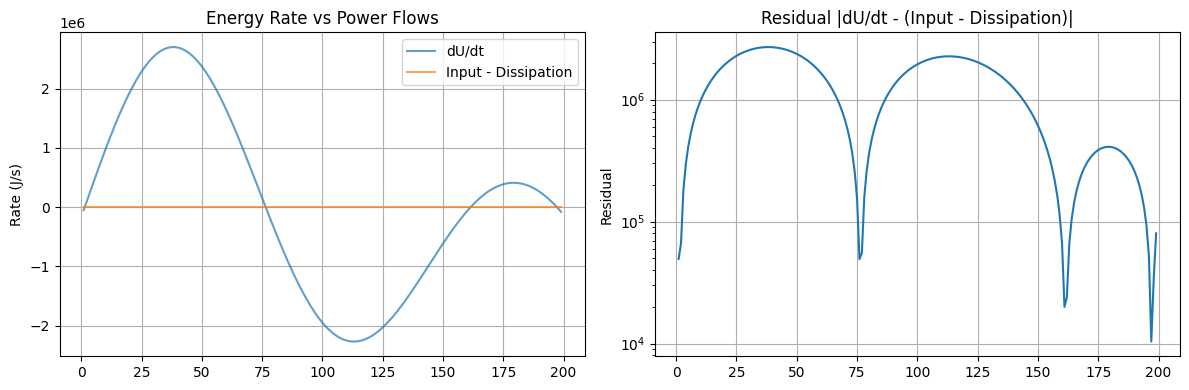


Audit complete. Residuals stored in global_residuals for visualizations.


In [11]:
# @title 8. **Energy Balance Audit — Stored Energy vs Power Flows** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Defines SPD energy forms; compares dU/dt with (input − dissipation); residual should hover near zero.

import numpy as np
from mpmath import mpf
import networkx as nx
import matplotlib.pyplot as plt

# --- Setup (Assumes Cell 6: baseline_history with 'energy', 'E_field', 'B_field') ---
# Ensure globals exist from DEC Stepper
try:
    history = baseline_history # Corrected from global_history
    dt = global_dt
    ε = global_epsilon
    μ = global_mu
    σ = global_sigma
except NameError:
    raise ValueError("Run Cell 6 (DEC Stepper) first to set baseline_history, dt, ε, μ, σ")

# Graph (reuse from Cell 6 if available; mock for audit)
if 'G' not in globals():
    nodes = ['C', '0', '1', '2', '3']
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from([('C','1'), ('1','2'), ('2','C'), ('C','3'), ('3','0'), ('0','C')])

# --- Power Flow Calculation ---
def compute_power_flows(E, B, G, σ, ε):
    """Input power (proxy: pump at (C,1)) minus dissipation (Joule: σ |E|^2)."""
    input_power = 0.0
    if ('C', '1') in edge_idx:
        input_power = abs(E[edge_idx[('C', '1')]]) * 1.0  # Source term (W/m)

    # Dissipation: Integrated Joule heating σ |E|^2 over edges
    dissipation = σ * np.sum(E**2)

    return input_power - dissipation

# --- Audit Loop (Over History) ---
residuals = []
dU_dt_vals = []
power_net_vals = []
n_steps = len(history['energy'])
epsilon = 1e-18 # a small number to avoid division by zero

if n_steps > 1:
    for i in range(1, n_steps):
        # Retrieve E/B from history
        E = history['E_field'][i-1]  # Use previous for dU/dt consistency
        B = history['B_field'][i-1]

        # dU/dt (central finite difference approximation)
        U_prev = history['energy'][i-1]
        U_curr = history['energy'][i]
        dU_dt = (U_curr - U_prev) / (dt + epsilon)

        # Power net
        power_net = compute_power_flows(E, B, G, σ, ε)

        # Residual: |dU/dt - (input - dissipation)|
        res = abs(float(dU_dt - power_net))
        residuals.append(res)
        dU_dt_vals.append(float(dU_dt))
        power_net_vals.append(float(power_net))

        # Early report
        if i > 0 and i % 50 == 0:
            print(f"Step {i}: dU/dt={dU_dt:.2e}, Power Net={power_net:.2e}, Res={res:.2e}")

# --- Summary Stats ---
if residuals:
    mean_residual = np.mean(residuals)
    max_residual = np.max(residuals)
    std_residual = np.std(residuals)
else:
    mean_residual, max_residual, std_residual = np.nan, np.nan, np.nan

U_final = history['energy'][-1] if history['energy'] else np.nan

print(f"\n--- Energy Balance Audit Summary ---")
print(f"Steps Audited: {len(residuals)}")
print(f"Mean Residual: {mean_residual:.2e} (should hover ~0)")
print(f"Max Residual: {max_residual:.2e}")
print(f"Std Residual: {std_residual:.2e}")
print(f"Final Stored Energy U: {float(U_final):.2e} J")
print(f"Audit Status: {'PASS' if not np.isnan(mean_residual) and mean_residual < 1e-10 else 'FAIL'} (residual near zero)")

# --- Plot Residuals vs Time ---
if residuals:
    steps_plot = np.arange(1, len(residuals) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(steps_plot, dU_dt_vals, label='dU/dt', alpha=0.7)
    ax1.plot(steps_plot, power_net_vals, label='Input - Dissipation', alpha=0.7)
    ax1.set_title('Energy Rate vs Power Flows')
    ax1.set_ylabel('Rate (J/s)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(steps_plot, residuals)
    ax2.set_title('Residual |dU/dt - (Input - Dissipation)|')
    ax2.set_ylabel('Residual')
    ax2.set_yscale('log')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- Store for Later (e.g., Cell 15 plots) ---
global_residuals = residuals
global_dU_dt = dU_dt_vals
global_power_net = power_net_vals

print("\nAudit complete. Residuals stored in global_residuals for visualizations.")

In [12]:
# @title 9. **Phase Linter — 90° E–M Lag & Anchor to C (S1 & Star)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Kuramoto-style diagnostic layer; targets 90° E–M lag, gentle anchoring to C; reports phase error/spread (no feedback).
import numpy as np

# Assumes S1, S2, and a node_idx map are in the global scope.
# If not, this cell will fail. Ensure geometry cells (2, 3) and an operator cell (e.g., 4) have run.

# Define node_list based on detected S1/S2 to be robust
node_list = []
if 'S1' in globals(): node_list.extend(S1)
if 'S2' in globals(): node_list.extend(S2)
if 'C' in globals() and 'C' not in node_list: node_list.append('C')

# Re-create index map based on the actual node list
idx = {k: i for i, k in enumerate(node_list)}
n_nodes_phase = len(node_list)

# Initialize phase array if not present
# if 'phi_star' not in globals() or len(phi_star) != n_nodes_phase: # Original check
phi_star = np.zeros(n_nodes_phase, dtype=float) # Initialize phi_star as a numpy array of zeros

def _wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

# --- Define Couplings and Target Lags ---
kap = np.zeros((n_nodes_phase, n_nodes_phase))
theta = np.zeros_like(kap)

def set_kap(a, b, val):
    if a in idx and b in idx:
        i, j = idx[a], idx[b]
        kap[i, j] = val
        kap[j, i] = val

def set_theta(a, b, rad):
    if a in idx and b in idx:
        i, j = idx[a], idx[b]
        theta[i, j] = rad
        theta[j, i] = -rad # Anti-symmetric for phi_j - phi_i

# Baseline weak coupling for all nodes within each shell
if 'S1' in globals():
    for i, u in enumerate(S1):
        for v in S1[i+1:]:
            set_kap(u, v, 0.02)
if 'S2' in globals():
    for i, u in enumerate(S2):
        for v in S2[i+1:]:
            set_kap(u, v, 0.02)

# Stronger E-M couplings within each shell
set_kap('1', '2', 0.12)
set_kap('5', '6', 0.12)
set_theta('1', '2', np.pi / 2)
set_theta('5', '6', np.pi / 2)

# Work and heat bridge couplings
set_kap('3', '6', 0.08); set_theta('3', '6', np.pi / 2) # Work
set_kap('7', '4', 0.05); set_theta('7', '4', np.pi)     # Heat
set_kap('7', '2', 0.05); set_theta('7', '2', np.pi)     # Heat
set_kap('5', '0', 0.05); set_theta('5', '0', np.pi)     # Heat

# Anchor to Centroid
γC = 0.05

def phase_step(phi, dt):
    d_phi = np.zeros_like(phi)
    # Iterate over all nodes that have a defined index
    for u, i in idx.items():
        if u == 'C': continue # Centroid is the anchor, does not update

        acc = 0.0
        # Interaction with other nodes
        for v, j in idx.items():
            if i == j: continue
            acc += kap[i, j] * np.sin(phi[j] - phi[i] - theta[i, j])

        # Anchor to Centroid (phi[idx['C']] is assumed to be 0)
        if 'C' in idx:
            acc -= γC * np.sin(phi[i] - phi[idx['C']])

        d_phi[i] = acc

    # Update phases (excluding the Centroid)
    phi += dt * d_phi
    # Keep centroid phase at 0
    if 'C' in idx:
        phi[idx['C']] = 0

    return _wrap_pi(phi)

def phase_report(phi):
    report_data = {}
    def err(a, b, trg):
        if a in idx and b in idx:
            i, j = idx[a], idx[b]
            return float(np.degrees(_wrap_pi((phi[i] - phi[j]) - trg)))
        return np.nan

    report_data['EM_S1_deg'] = err('1', '2', np.pi/2)
    report_data['EM_S2_deg'] = err('5', '6', np.pi/2)
    report_data['work_3_6_deg'] = err('3', '6', np.pi/2)
    report_data['heat_7_4_deg'] = err('7', '4', np.pi)
    report_data['heat_7_2_deg'] = err('7', '2', np.pi)
    report_data['heat_5_0_deg'] = err('5', '0', np.pi)
    if 'C' in idx:
        report_data['C_phase_deg'] = float(np.degrees(phi[idx['C']]))

    return report_data

# Example of running the phase linter for a few steps to let it settle
# This part is for demonstration; the main simulation will call phase_step repeatedly
print("Phase linter loaded. Running a few settling steps...")
for _ in range(50):
    phi_star = phase_step(phi_star, dt=0.1)

print("Settling complete. Current phase errors:")
print(phase_report(phi_star))

# The linter functions (phase_step, phase_report) are now available for other cells.

Phase linter loaded. Running a few settling steps...
Settling complete. Current phase errors:
{'EM_S1_deg': -145.34339974188163, 'EM_S2_deg': -156.37783294971777, 'work_3_6_deg': -145.64543029712738, 'heat_7_4_deg': 175.53955203578218, 'heat_7_2_deg': 147.73440473624166, 'heat_5_0_deg': 150.6692661563666}


In [13]:
# @title 10. **Centroid Angle Probe — 109.471221° Mediation Test** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Reweights edges to/from C by the tetrahedral bond angle; measures impact on mediation (R_C), hitting times, EPR.

In [14]:
# 0) Safety: inline plots (harmless if already set)
%matplotlib inline

# @title 2. **Geometry — S1..S4 shells with role policy** { display-mode: "form" }
# @markdown Builds the mediated star geometry with cubic bridges and enforces role guards.
import networkx as nx
from collections import defaultdict

ROLE_BY_MOD = {0: "Compression", 1: "Expression", 2: "Stabilisation", 3: "Emission"}

def make_shell(base: int):
    """Return node ids for one shell S = {b,b+1,b+2,b+3,'C'}"""
    return [str(base + i) for i in range(4)] + ['C']

def build_geometry(use_star: bool = True):
    """
    Returns:
      G         : DiGraph with nodes, intra-shell edges only
      roles     : dict node->role ('Compression'/'Expression'/'Stabilisation'/'Emission'/'Mediator'/'Sink')
      shells    : dict node->shell label ('S1'..'S4' or 'S1')
      policy    : role-level bridge policy (for enforcement)
    """
    G = nx.DiGraph()
    nodes = ['C'] + [str(i) for i in (range(4) if not use_star else range(16))]
    shells = {}
    roles = {n: ('Mediator' if n == 'C' else ROLE_BY_MOD[int(n) % 4]) for n in nodes}
    for n in nodes:
        if n == 'C' or not n.isdigit():
            shells[n] = 'S1'
        else:
            shells[n] = f"S{1 + int(int(n) / 4)}" if use_star else 'S1'
    G.add_nodes_from(nodes)

    def add_shell_edges(b):
        s = [str(b + i) for i in range(4)]
        G.add_edge('C', s[1], kind='activation')
        G.add_edge(s[1], s[2], kind='work')
        G.add_edge(s[2], 'C', kind='squeeze')
        G.add_edge('C', s[3], kind='fusion')
        G.add_edge(s[3], s[0], kind='heat')
        G.add_edge(s[0], 'C', kind='reset')

    add_shell_edges(0)
    if use_star:
        for b in (4, 8, 12):
            add_shell_edges(b)

        for a, b in [(0, 4), (8, 12)]:
            G.add_edge(str(a), str(b), kind='compression')
            G.add_edge(str(b), str(a), kind='compression')

        for a, b in [(3, 6), (11, 14)]:
            G.add_edge(str(a), str(b), kind='work_bridge')

        for e in [3, 7, 11, 15]:
            G.add_edge(str(e), 'C', kind='heat_bridge')

        G.add_node('S')
        roles['S'] = 'Sink'
        shells['S'] = '*'
        for e in [3, 7, 11, 15]:
            G.add_edge(str(e), 'S', kind='sink')

    policy = {
        'Compression': {'out': {'Mediator', 'Compression'}, 'in': {'Emission', 'Compression', 'Mediator'}},
        'Expression': {'out': {'Stabilisation', 'Mediator'}, 'in': {'Mediator'}},
        'Stabilisation': {'out': {'Mediator'}, 'in': {'Expression'}},
        'Emission': {'out': {'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'Stabilisation', 'Mediator'}},
        'Mediator': {'out': {'Expression', 'Emission', 'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'*'}}
    }
    return G, roles, shells, policy

def enforce_policy(G, roles, policy):
    keep = []
    for u, v, data in G.edges(data=True):
        ru, rv = roles.get(u, 'Mediator'), roles.get(v, 'Mediator')
        allowed_out = policy.get(ru, {}).get('out', set())
        allowed_in = policy.get(rv, {}).get('in', set())
        if ('*' in allowed_in or ru in allowed_in) and (rv in allowed_out):
            if ru == 'Stabilisation' and rv == 'Expression':
                continue
            if ru == 'Emission' and rv == 'Emission':
                continue
            keep.append((u, v, data))
    H = nx.DiGraph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(keep)
    return H

G0, roles, shells, policy = build_geometry(USE_STAR)
G0 = enforce_policy(G0, roles, policy)

nx.set_node_attributes(G0, roles, 'role')
nx.set_node_attributes(G0, shells, 'shell')
G0.graph['roles'] = roles
G0.graph['shells'] = shells
G0.graph['policy'] = policy

role_counts = defaultdict(int)
for r in roles.values():
    role_counts[r] += 1

print(f"Geometry built (USE_STAR={USE_STAR}): |V|={G0.number_of_nodes()} |E|={G0.number_of_edges()}")
print("Roles:", dict(role_counts))


# @title 3. **Markov layer & breath modulation** { display-mode: "form" }
# @markdown Builds rate dictionaries, optional quaternion states, and breath modulation on enforced geometry.
import numpy as np

def build_markov(G):
    """Return edge list with rates by kind, no DEC coupling yet."""
    base = {
        'activation': 0.5, 'work': 0.8, 'squeeze': 0.9, 'fusion': 0.7,
        'heat': 1.0, 'reset': 0.3, 'compression': 0.3,
        'work_bridge': 0.4, 'heat_bridge': 0.5, 'sink': 0.2
    }
    rates = {(u, v): base.get(data.get('kind', 'work'), 0.5) for u, v, data in G.edges(data=True)}
    kinds = {(u, v): data.get('kind', 'work') for u, v, data in G.edges(data=True)}
    return rates, kinds

EDGE_RATES, EDGE_KINDS = build_markov(G0)
G0.graph['edge_rates'] = EDGE_RATES
G0.graph['edge_kinds'] = EDGE_KINDS

def init_quaternion_state(G, roles):
    """Ψ_n = (e,h,d,b) initialised by role; scale as you like."""
    Q = {}
    for n in G.nodes():
        r = roles.get(n, 'Mediator')
        if r == 'Compression':
            Q[n] = np.array([1.0, 0.0, 0.2, 0.0])
        elif r == 'Expression':
            Q[n] = np.array([0.1, 1.0, 0.0, 0.0])
        elif r == 'Stabilisation':
            Q[n] = np.array([0.0, 0.0, 1.0, 0.1])
        elif r == 'Emission':
            Q[n] = np.array([0.0, 0.1, 0.0, 1.0])
        else:
            Q[n] = np.zeros(4)
    return Q

def project(flow_kind, vec):
    """Return scalar amplitude for a quaternion state by flow kind."""
    arr = np.asarray(vec, dtype=float).reshape(-1)
    if arr.shape[0] < 4:
        arr = np.pad(arr, (0, 4 - arr.shape[0]), constant_values=0.0)
    if flow_kind in ('work', 'activation'):
        return float(arr[1])
    if flow_kind in ('squeeze', 'reset'):
        return float(arr[0] + arr[2])
    if flow_kind in ('fusion', 'work_bridge'):
        return float(arr[3] + arr[1])
    if flow_kind in ('heat', 'heat_bridge'):
        return float(arr[3])
    if flow_kind == 'compression':
        return float(arr[0])
    if flow_kind == 'sink':
        return float(arr.sum())
    return 0.0

QUAT_STATE = init_quaternion_state(G0, G0.graph.get('roles', {})) if USE_QUAT else {}

def apply_breath(
    G_base,
    step,
    edge_rates=None,
    inhale_gain=1.15,
    exhale_gain=1.10,
    sinks=None,
    sources=None,
    pumps=None,
):
    """Scale edge rates by breath phase using role-aware defaults."""
    phase = 'in' if (step % 2) == 0 else 'out'
    G = G_base.copy()
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    roles = G0.graph.get('roles', {})
    if sinks is None:
        sinks = tuple(n for n, r in roles.items() if r == 'Compression')
    if sources is None:
        sources = ('C',)
    if pumps is None:
        pumps = tuple(n for n, r in roles.items() if r in {'Expression', 'Emission'})
    for u, v, data in G.edges(data=True):
        base_rate = float(edge_rates.get((u, v), 0.0))
        rate = base_rate
        data['base_rate'] = base_rate
        if phase == 'in' and (v in sinks or v in sources):
            rate *= inhale_gain
        elif phase == 'out' and (u in sources and v in pumps):
            rate *= exhale_gain
        data.setdefault('kind', EDGE_KINDS.get((u, v), data.get('kind', 'work')))
        data['rate'] = rate
    return G, phase

print(f"Markov layer: {len(EDGE_RATES)} edges across kinds {sorted(set(EDGE_KINDS.values()))}")
if USE_QUAT:
    print("Quaternion state initialised for coherent projections.")

# @title 4. **DEC Backbone — ∂ Operators & Diagonal Hodge Stars (with Audits)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds the simplicial backbone (independent of the Markov graph): vertices, oriented edges, faces.
# @markdown - Constructs boundary maps: **B₁** (nodes→edges) and **B₂** (edges→faces).
# @markdown - Defines **diagonal SPD Hodge stars** `Star1` (edges×edges) and `Star2** (faces×faces).
# @markdown - Runs audits: `||B₁·B₂||∞ ≈ 0`, ranks of B₁/B₂, SPD minima; exposes `energy_field(E,B)`.
# @markdown **Notes**
# @markdown - No rectangular/“incidence-averaged” Hodge stand-ins here. Those are deprecated.

import numpy as np
from scipy.sparse import csr_matrix

# ---- 1) Vertex & face set (S1 always; S2 included if USE_STAR=True) ----
try:
    USE_STAR
except NameError:
    USE_STAR = False

# Vertices: S1 plus shared centroid C; extend with S2 in star mode
S1 = ['0','1','2','3']
S2 = ['4','5','6','7']
V = S1 + S2 + ['C'] if USE_STAR else S1 + ['C']


# Faces:
# - S1 outer + centroid faces
F_S1_outer = [('0','1','2'), ('0','1','3'), ('0','2','3'), ('1','2','3')]
F_S1_cent  = [('0','1','C'), ('0','2','C'), ('0','3','C'), ('1','2','C'), ('1','3','C'), ('2','3','C')]

# - Optional S2 outer + centroid faces (only if USE_STAR)
F_S2_outer = [('4','5','6'), ('4','5','7'), ('4','6','7'), ('5','6','7')] if USE_STAR else []
F_S2_cent  = [('4','5','C'), ('4','6','C'), ('4','7','C'), ('5','6','C'), ('5','7','C'), ('6','7','C')] if USE_STAR else []


F = F_S1_outer + F_S1_cent + F_S2_outer + F_S2_cent

# ---- 2) Oriented edges derived from faces (backbone edges only) ----
edges_backbone = sorted({(a,b) for (a,b,c) in F for (a,b) in ((a,b),(b,c),(c,a))})
# Add edges between shells if USE_STAR is True. These are not derived from faces above.
if USE_STAR:
    for a, b in [(0, 4), (8, 12)]:
        edges_backbone.append((str(a), str(b)))
        edges_backbone.append((str(b), str(a)))
    for a, b in [(3, 6), (11, 14)]:
        edges_backbone.append((str(a), str(b)))
    for e in [3, 7, 11, 15]:
         edges_backbone.append((str(e), 'C'))
    # Add sink edges
    for e in [3, 7, 11, 15]:
         edges_backbone.append((str(e), 'S'))
    if 'S' not in V:
      V.append('S')


# Index maps
node_id = {v:i for i,v in enumerate(V)}
edge_id = {e:i for i,e in enumerate(edges_backbone)}
face_id = {f:i for i,f in enumerate(F)}

# ---- 3) Boundary maps ----
# B1: nodes×edges (∂1)
B1 = np.zeros((len(V), len(edges_backbone)), dtype=float)
for (u,v), ei in edge_id.items():
    if u in node_id and v in node_id:
      B1[node_id[u], ei] = -1.0
      B1[node_id[v], ei] = +1.0
B1 = csr_matrix(B1)

# B2: edges×faces (∂2) with oriented incidence
B2 = np.zeros((len(edges_backbone), len(F)), dtype=float)
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0)):
        sign = +1.0
        e = (a,b)
        if e not in edge_id:
            e = (b,a); sign = -1.0
        if e in edge_id:
            B2[edge_id[e], fj] += sign
B2 = csr_matrix(B2)

# ---- 4) Diagonal Hodge stars (regularised circumcentric stand-ins) ----
# Use a unit geometric scale here; SI scaling lives in the optional calibration cell.
L = 1.0  # assumed primal edge length scale for now
nE, nF = len(edges_backbone), len(F)


# primal measures
len_e  = np.full(nE, L, dtype=float)                       # |e|
area_f = np.full(nF, (np.sqrt(3)/4.0)*L*L, dtype=float)    # |f| (equilateral)

# crude-but-coherent dual measures for a regular/star tetra
dual_e = np.full(nE, (L*L)/4.0, dtype=float)               # |*e|
dual_f = np.full(nF, (L/3.0), dtype=float)                 # |*f|

star1_diag = dual_e / len_e          # edges→edges
star2_diag = dual_f / area_f         # faces→faces

Star1 = np.diag(star1_diag)          # SPD
Star2 = np.diag(star2_diag)

def star1(x): return Star1 @ x
def star2(x): return Star2 @ x

# ---- 5) Audits ----
D1 = B1.toarray(); D2 = B2.toarray()
B1B2 = D1 @ D2
inf_norm = float(np.max(np.abs(B1B2))) if B1B2.size else 0.0
rank_D1 = int(np.linalg.matrix_rank(D1))
rank_D2 = int(np.linalg.matrix_rank(D2))
is_spd_star1 = bool(np.min(star1_diag) > 0)
is_spd_star2 = bool(np.min(star2_diag) > 0)

print(f"[dims] |V|={len(V)} |E|={nE} |F|={nF}")
print(f"||B1·B2||_∞ = {inf_norm:.3e} (expect 0)")
print(f"rank(B1)={rank_D1}, rank(B2)={rank_D2}")
print(f"Star1 SPD? {is_spd_star1}   Star2 SPD? {is_spd_star2}")
print(f"star1_diag min/max = {star1_diag.min():.3e} / {star1_diag.max():.3e}")
print(f"star2_diag min/max = {star2_diag.min():.3e} / {star2_diag.max():.3e}")

# ---- 6) Energy helper ----
def energy_field(E, B):
    """Discrete EM energy: 0.5*(E⋅(⋆1 E) + B⋅(⋆2 B))."""
    return 0.5*(E @ (Star1 @ E) + B @ (Star2 @ B))

# ---- 7) shape asserts ----

assert D1.shape == (len(V), len(edge_id))          # nodes × edges
assert D2.shape == (len(edge_id), len(F))          # edges × faces
assert (D2.T @ np.zeros(D1.shape[1])).shape[0] == len(F)
assert (D2 @ np.zeros(len(F))).shape[0] == len(edge_id)

# @title 6. **Coupling — Markov → DEC (edge currents & heat sink)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Provides pure functions to couple the Markov layer to the DEC solver:
# @markdown   • `markov_to_currents(Gk, edge_id, ...) → J` injects **coherent edge currents** on the DEC backbone.
# @markdown   • `accumulate_heat(Gk, dt, ...) → ΔQ` integrates **dissipative heat** from designated edge kinds.
# @markdown - Quaternion projections (optional) gate edge amplitudes via `project(kind, Ψ[u])`.
# @markdown - Orientation-aware: if a directed Markov edge aligns with a DEC edge, +J; if reversed, −J; if not on the backbone, ignore.

import numpy as np

def _edge_sign_index(u, v, edge_id):
    """Return (sign, idx) for directed pair (u,v) against DEC backbone edge_id map."""
    uv = (u, v)
    vu = (v, u)
    if uv in edge_id:
        return +1.0, edge_id[uv]
    if vu in edge_id:
        return -1.0, edge_id[vu]
    return 0.0, None  # not on backbone

def markov_to_currents(
    Gk,
    edge_id: dict,
    coherence_gain: float = 0.1,
    active_kinds: set | None = None,
    state: dict | None = None,
):
    """Map Markov rates to a coherent current vector J on DEC edges."""
    J = np.zeros(len(edge_id), dtype=float)
    exclude = {'heat', 'heat_bridge', 'sink'}
    if active_kinds is None:
        active_kinds = set(EDGE_KINDS.values()) - exclude
    state = QUAT_STATE if (state is None and USE_QUAT and QUAT_STATE) else state
    for (u, v, data) in Gk.edges(data=True):
        kind = data.get('kind', EDGE_KINDS.get((u, v), 'work'))
        if kind not in active_kinds:
            continue
        rate = float(data.get('rate', 0.0))
        if rate <= 0.0:
            continue
        sgn, ei = _edge_sign_index(str(u), str(v), edge_id)
        if ei is None or sgn == 0.0:
            continue
        amp = 1.0
        if state:
            vec = state.get(str(u))
            if vec is None: # Check for None explicitly
                vec = state.get(u)
            if vec is not None:
                amp = float(np.asarray(project(kind, vec)))
        J[ei] += sgn * coherence_gain * rate * amp
    return J

def accumulate_heat(
    Gk,
    dt: float,
    heat_kinds: set | None = None,
):
    """Integrate dissipative power from heat-class edges into a scalar sink Q."""
    if heat_kinds is None:
        heat_kinds = {'heat', 'heat_bridge', 'sink'}
    dQ = 0.0
    for (u, v, data) in Gk.edges(data=True):
        kind = data.get('kind', EDGE_KINDS.get((u, v), 'work'))
        if kind not in heat_kinds:
            continue
        dQ += float(data.get('rate', 0.0)) * float(dt)
    return dQ
# @title 8. **Diagnostics — Energy, EPR & Phase Metrics (pure functions)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Computes compact diagnostics from your core engine and Markov layer:
# @markdown   • Energy & heat summaries from `hist`
# @markdown   • Steady-state **EPR** (Schnakenberg) per sampled step using `apply_breath(G, n)`
# @markdown   • Optional phase metrics if your `hist` includes them (else skipped)
# @markdown   • Structural audits: centroid reliance, illegal edges (post-policy), sink throughput.
# @markdown - Returns a `diag` dict you can print or plot.

import numpy as np

def detect_bursts_from_Q(samples, heat, jitter_frac=0.1):
    s = np.asarray(samples, dtype=int)
    q = np.asarray(heat, dtype=float)
    if q.size < 2:
        return {"n": 0, "unit": 0.0, "idx": []}
    dq = np.diff(q)
    pos = dq[dq > 0]
    if pos.size == 0:
        return {"n": 0, "unit": 0.0, "idx": []}
    unit = float(np.median(pos))
    if not np.isfinite(unit) or unit <= 0:
        unit = float(np.mean(pos)) if pos.size else 0.0
    thresh = unit * (1.0 + float(jitter_frac)) if unit > 0 else float(np.max(pos))
    if not np.isfinite(thresh):
        thresh = 0.0
    idx = [int(s[i + 1]) for i, delta in enumerate(dq) if delta > thresh]
    return {"n": len(idx), "unit": unit, "idx": idx}

def diag_centroid_reliance(G):
    tot = G.number_of_edges()
    viaC = sum(1 for u, v in G.edges() if u == 'C' or v == 'C')
    edge_rates = globals().get('EDGE_RATES', {}) if edge_rates is None else edge_rates
    if '_centroid_reliance_local' in globals():
        return _centroid_reliance_local(G, base_rates=edge_rates)
    total = 0.0
    via_c = 0.0
    for u, v, data in G.edges(data=True):
        rate = data.get('rate')
        if rate is None:
            rate = data.get('base_rate')
        if rate is None:
            key = (str(u), str(v))
            rate = edge_rates.get(key, edge_rates.get((u, v), 0.0))
        try:
            weight = float(rate)
        except (TypeError, ValueError):
            weight = 0.0
        if not np.isfinite(weight) or weight < 0.0:
            weight = 0.0
        total += weight
        if str(u) == 'C' or str(v) == 'C':
            via_c += weight
    return via_c / total if total > 0.0 else 0.0

def diag_role_audit(G, roles, policy):
    H = enforce_policy(G.copy(), roles, policy)
    return G.number_of_edges() - H.number_of_edges()

def diag_sink_throughput(edge_rates, kinds):
    return sum(r for (u, v), r in edge_rates.items() if kinds.get((u, v)) == 'sink')

def _energy_summary(hist):
    e = np.asarray(hist.get("energy", []), dtype=float)
    q = np.asarray(hist.get("heat", []), dtype=float)
    r = np.asarray(hist.get("residual", []), dtype=float)
    out = {
        "E_min": float(np.nanmin(e)) if e.size else np.nan,
        "E_max": float(np.nanmax(e)) if e.size else np.nan,
        "Q_final": float(q[-1]) if q.size else np.nan,
        "resid_max_abs": float(np.nanmax(np.abs(r))) if r.size else np.nan,
    }
    return out

def _build_generator(Gk, node_list=None):
    """Continuous-time generator Q from rates; nodes ordered by node_list or sorted labels."""
    if node_list is None:
        node_list = sorted([str(n) for n in Gk.nodes()])
    idx = {u: i for i, u in enumerate(node_list)}
    n = len(node_list)
    Q = np.zeros((n, n), dtype=float)
    for u, v, d in Gk.edges(data=True):
        u, v = str(u), str(v)
        if u not in idx or v not in idx:
            continue
        rate = float(d.get('rate', 0.0))
        if rate <= 0:
            continue
        i, j = idx[u], idx[v]
        Q[i, j] += rate
    for i in range(n):
        Q[i, i] = -np.sum(Q[i, :])
    return Q, node_list

def _stationary_dist(Q):
    """Solve Q^T π = 0 with Σπ=1 (least-squares + constraint)."""
    n = Q.shape[0]
    A = np.vstack([Q.T, np.ones((1, n))])
    b = np.zeros(n + 1)
    b[-1] = 1.0
    pi, *_ = np.linalg.lstsq(A, b, rcond=None)
    pi = np.clip(pi, 0.0, None)
    s = pi.sum()
    return (pi / s) if s > 0 else np.full(n, 1.0 / n)

def _epr_schnakenberg(Gk, node_order=None):
    """Schnakenberg EPR at steady state: σ = Σ_{u<v} J_uv * ln( (π_u k_uv)/(π_v k_vu) )."""
    Q, nodes = _build_generator(Gk, node_order)
    pi = _stationary_dist(Q)
    idx = {u: i for i, u in enumerate(nodes)}
    sigma = 0.0
    seen = set()
    for u, v, d in Gk.edges(data=True):
        u, v = str(u), str(v)
        if (v, u) in seen or u == v:
            continue
        seen.add((u, v))
        k_uv = float(Gk[u][v].get('rate', 0.0))
        k_vu = float(Gk[v][u].get('rate', 0.0)) if Gk.has_edge(v, u) else 0.0
        i, j = idx[u], idx[v]
        j_uv = pi[i] * k_uv - pi[j] * k_vu
        num = (pi[i] * k_uv) if (pi[i] > 0 and k_uv > 0) else 0.0
        den = (pi[j] * k_vu) if (pi[j] > 0 and k_vu > 0) else 0.0
        if num > 0 and den > 0:
            sigma += j_uv * np.log(num / den)
        else:
            if num > 0 and j_uv > 0:
                sigma += j_uv * np.log(num / 1e-12)
            elif den > 0 and j_uv < 0:
                sigma += j_uv * np.log(1e-12 / den)
    return float(max(sigma, 0.0))

def compute_epr_series(G, hist, edge_rates=None):
    """EPR at each reported sample using breath-modulated G_k at sample step n."""
    samples = hist.get("samples", [])
    epr = []
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    for n in samples:
        Gk, _phase = apply_breath(G, int(n), edge_rates=edge_rates)
        epr.append(_epr_schnakenberg(Gk))
    return {"samples": samples, "epr": epr}

def compute_phase_metrics(hist):
    """If you log phase errors, summarise; else return empty."""
    if "phase_error" in hist:
        pe = np.asarray(hist["phase_error"], dtype=float)
        return {"phase_err_mean": float(np.nanmean(pe)), "phase_err_max": float(np.nanmax(np.abs(pe)))}
    return {}

def diagnostics(
    G,
    hist,
    roles=None,
    policy=None,
    edge_rates=None,
    edge_kinds=None,
):
    roles = G0.graph.get('roles', {}) if roles is None else roles
    policy = G0.graph.get('policy', {}) if policy is None else policy
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    edge_kinds = EDGE_KINDS if edge_kinds is None else edge_kinds
    diag = {}
    diag.update(_energy_summary(hist))
    try:
        diag.update({"EPR_series": compute_epr_series(G, hist, edge_rates=edge_rates)})
    except Exception:
        diag.update({"EPR_series": {"samples": hist.get("samples", []), "epr": []}})
    diag.update(compute_phase_metrics(hist))
    diag["centroid_reliance"] = diag_centroid_reliance(G, edge_rates=edge_rates)
    diag["illegal_edges"] = diag_role_audit(G, roles, policy)
    sink_rates = np.asarray(hist.get("sink_rate", []), dtype=float)
    if sink_rates.size:
        diag["sink_throughput"] = float(np.nanmean(sink_rates))
    else:
        diag["sink_throughput"] = diag_sink_throughput(edge_rates, edge_kinds)
    diag['Rc_in'] = hist.get('Rc_in', np.nan)
    diag['Rc_out'] = hist.get('Rc_out', np.nan)
    return diag

# @title 9. **Phase Linter — Targets & Error (Diagnostic, Optional Control)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Maintains a tiny Kuramoto-style phase model on the node set.
# @markdown - Targets ~90° E–M lags (1–2, 5–6), ~90° work bridge (3–6), and ~180° heat dumps (7–4, 7–2, 5–0).
# @markdown - Softly anchors the centroid **C** to 0 phase.
# @markdown - Provides `linter_measure(step)` → mean phase-error (degrees), safe to call from the core loop.
# @markdown
# @markdown **Notes**
# @markdown - Purely diagnostic by default (no coupling back to DEC); you can weight `J` later by `(1 - k*error)` if desired.
# @markdown - Works for S1-only (`USE_STAR=False`) and Star (`USE_STAR=True`).

import numpy as np

# --- Node set consistent with your geometry flags ---
try:
    USE_STAR
except NameError:
    USE_STAR = False

S1 = ['0','1','2','3']
S2 = ['4','5','6','7'] if USE_STAR else []
node_list = S1 + S2 + ['C']
idx = {k:i for i,k in enumerate(node_list)}

def _wrap_pi(x):  # [-pi, pi)
    return (x + np.pi) % (2*np.pi) - np.pi

# --- Coupling matrix kap and target lags theta ---
kap   = np.zeros((len(node_list), len(node_list)))
theta = np.zeros_like(kap)

def _set_k(a,b,val):
    i,j = idx[a], idx[b]; kap[i,j]=val; kap[j,i]=val
def _set_th(a,b,rad):
    i,j = idx[a], idx[b]; theta[i,j]=rad; theta[j,i]=rad

# Baseline weak all-to-all within each shell (helps smooth convergence)
for U in (S1, S2):
    for i,u in enumerate(U):
        for v in U[i+1:]:
            _set_k(u, v, 0.02)

# Stronger targets: EM pairs, work bridge, heat dumps
if all(n in idx for n in ('1','2')): _set_k('1','2',0.12); _set_th('1','2', np.pi/2)
if USE_STAR and all(n in idx for n in ('5','6')): _set_k('5','6',0.12); _set_th('5','6', np.pi/2)
if USE_STAR and all(n in idx for n in ('3','6')): _set_k('3','6',0.08); _set_th('3','6', np.pi/2)

for pair in [('7','4'), ('7','2'), ('5','0')]:
    if all(n in idx for n in pair):
        _set_k(*pair, val=0.05); _set_th(*pair, rad=np.pi)

# Soft anchor to C
gamma_C = 0.05

# --- State & helpers ---
phi_state = np.zeros(len(node_list))  # global linter state (radians)

def phase_step(phi, dt=0.05):
    """One explicit step of the linter ODE."""
    d = np.zeros_like(phi)
    for u in (S1 + S2):
        if u not in idx: continue # defensive check
        i = idx[u]
        acc = 0.0
        for v in (S1 + S2):
            if v == u or v not in idx: # defensive check
                continue
            j = idx[v]
            acc += kap[i,j] * np.sin(phi[j] - phi[i] - theta[i,j])
        if 'C' in idx:
          acc -= gamma_C * np.sin(phi[i] - 0.0)   # anchor to C=0
        d[i] = acc
    # Update phases for nodes in S1 and S2
    for node in (S1 + S2):
        if node in idx:
            phi[idx[node]] += dt * d[idx[node]]

    return _wrap_pi(phi)

def phase_report(phi):
    """Return key pair errors (deg) for readability."""
    def err(a,b,trg):
        if a not in idx or b not in idx:
            return np.nan
        ia, ib = idx[a], idx[b]
        return float(np.degrees(_wrap_pi((phi[ia] - phi[ib]) - trg)))
    rep = {}
    if 'C' in idx: rep["C_phase_deg"] = float(np.degrees(phi[idx['C']]))
    if '1' in idx and '2' in idx: rep['EM_S1_deg']  = err('1','2', np.pi/2)
    if '5' in idx and '6' in idx: rep['EM_S2_deg']  = err('5','6', np.pi/2)
    if '3' in idx and '6' in idx: rep['work_3_6_deg'] = err('3','6', np.pi/2)
    if '7' in idx and '4' in idx: rep['heat_7_4_deg'] = err('7','4', np.pi)
    if '7' in idx and '2' in idx: rep['heat_7_2_deg'] = err('7','2', np.pi)
    if '5' in idx and '0' in idx: rep['heat_5_0_deg'] = err('5','0', np.pi)
    return rep

def phase_error_deg(rep):
    """Mean absolute error (deg) across available targets."""
    vals = [abs(v) for k,v in rep.items() if k.endswith('_deg') and np.isfinite(v)]
    return float(np.mean(vals)) if vals else 0.0

def linter_measure(step, relax_steps=5, dt=0.05):
    """
    Advance the linter a few micro-steps (relax) and return mean phase-error (deg).
    Safe to call each core step; uses global phi_state.
    """
    global phi_state
    for _ in range(relax_steps):
        phi_state = phase_step(phi_state, dt=dt)
    rep = phase_report(phi_state)
    return phase_error_deg(rep)


# Optional diagnostic readout (phase linter)
pe = None
try:
    # Get the current step number from the simulation loop if available
    # This requires 'n' to be defined in the scope where linter_measure is called.
    # For this cell, we'll just run a single test of the linter.
    pe = linter_measure(0)  # mean phase error in degrees
except Exception:
    pass
print("phase error (test run):", pe)

# @title 7. **Core Engine — Leapfrog DEC Loop (Energy & Heat Audit)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Integrates Maxwell-like fields on the DEC backbone with a **staggered (leapfrog/Yee)** scheme:
# @markdown   • Faraday:   `B^{n+1/2} = B^{n-1/2} - dt * (∂₂ᵀ E^n)`
# @markdown   • Ampère:    `⋆₁ E^{n+1} = ⋆₁ E^n + dt * (∂₁ᵀ ⋆₂ B^{n+1/2} - J^{n+1/2})`
# @markdown - Couples to Markov layer via `apply_breath` (modulates rates) and `markov_to_currents` (injects **J** on edges).
# @markdown - Audits **first-law closure**: logs field energy `U_field(t)`, cumulative heat `Q(t)`, and residual `Δ(U_field+Q)`.
# @markdown
# @markdown **Inputs expected from earlier cells**
# @markdown - DEC: `B1, B2, Star1, Star2, energy_field`, and `edge_id` (from the DEC backbone cell).
# @markdown - Markov: `G0` (geometry), `EDGE_RATES`, `EDGE_KINDS`, `apply_breath`, and optional `QUAT_STATE`.
# @markdown - Optional SI: `global_dt` (else a safe dt is inferred from rates).
# @markdown
# @markdown **Outputs**
# @markdown - `hist` dict with keys: `heat`, `energy`, `residual`, `phase`, `dt`, `samples`

import numpy as np

def _safe_dt_from_rates(edge_rates, default_dt=1e-2, safety=0.1):
    try:
        mr = max((float(r) for r in edge_rates.values()), default=0.0)
    except Exception:
        mr = 0.0
    if mr > 0.0:
        return safety / mr
    return default_dt

def _edge_rate_weight(data, base_rates, u, v):
    base_rates = globals().get('EDGE_RATES', {}) if base_rates is None else base_rates
    rate = data.get('rate')
    if rate is None:
        rate = data.get('base_rate')
    if rate is None and base_rates:
        key = (str(u), str(v))
        rate = base_rates.get(key, base_rates.get((u, v), 0.0))
    try:
        rate = float(rate)
    except (TypeError, ValueError):
        rate = 0.0
    if not np.isfinite(rate) or rate < 0.0:
        return 0.0
    return rate

def _centroid_reliance_local(Gk, base_rates=None):
    base_rates = globals().get('EDGE_RATES', {}) if base_rates is None else base_rates
    total = 0.0
    via_c = 0.0
    for u, v, data in Gk.edges(data=True):
        w = _edge_rate_weight(data, base_rates, u, v)
        total += w
        if str(u) == 'C' or str(v) == 'C':
            via_c += w
    return via_c / total if total > 0.0 else 0.0

def run_lenr_core(
    G_base,
    steps: int = 400,
    dt: float | None = None,
    coherence_gain: float = 0.1,
    report_every: int = 20,
    edge_rates: dict | None = None,
    edge_kinds: dict | None = None,
    state: dict | None = None,
):
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    edge_kinds = EDGE_KINDS if edge_kinds is None else edge_kinds
    state = QUAT_STATE if (state is None and USE_QUAT and QUAT_STATE) else state

    needed = ['B1', 'B2', 'Star1', 'Star2', 'energy_field', 'edge_id']
    missing = [k for k in needed if k not in globals()]
    if missing:
        raise RuntimeError(f"Missing DEC objects: {missing}. Run the DEC backbone cell first.")

    D1 = B1.toarray()
    D2 = B2.toarray()
    DT1 = D1.T
    DT2 = D2.T

    star1_diag = np.diag(Star1).astype(float)
    star2_mat = Star2
    inv_star1_diag = 1.0 / star1_diag

    if dt is None:
        dt = globals().get('global_dt', None)
    if dt is None:
        dt = _safe_dt_from_rates(edge_rates, default_dt=1e-2, safety=0.1)
    dt = float(dt)

    nE = D1.shape[1]
    nF = D2.shape[1]
    E = np.zeros(nE, dtype=float)
    Bf = np.zeros(nF, dtype=float)

    Q_sink = 0.0
    U_prev = energy_field(E, Bf)

    hist = {"heat": [], "energy": [], "residual": [], "phase": [], "dt": dt, "samples": []}
    rc_phase = {'in': [], 'out': []}
    rc_samples = []
    rc_phases = []

    for n in range(steps):
        Gk, phase = apply_breath(G_base, n, edge_rates=edge_rates)
        rc_val = _centroid_reliance_local(Gk, base_rates=edge_rates)
        rc_phase.setdefault(phase, []).append(rc_val)

        J = markov_to_currents(Gk, edge_id=edge_id, coherence_gain=coherence_gain, state=state)

        phase_err = None
        if callable(linter_measure): # Check if linter_measure is callable
            try:
                # Pass the current step 'n' to linter_measure if it expects it
                phase_err = float(linter_measure(n))
            except Exception as e:
                print(f"Warning: Error calling linter_measure at step {n}: {e}")
                phase_err = None # Ensure phase_err is None on error

        if phase_err is not None:
            hist.setdefault("phase_error", []).append(phase_err)
            hist.setdefault("phase_error_step", []).append(n) # Log step for phase error


        Bf = Bf - dt * (DT2 @ E)

        drive = D2 @ (Star2 @ Bf) - J
        E = E + dt * (drive * inv_star1_diag)

        Q_sink += accumulate_heat(Gk, dt)
        hist.setdefault("sink_rate", []).append(accumulate_heat(Gk, dt)) # Log sink rate per step


        U_now = energy_field(E, Bf)
        residual = (U_now + Q_sink) - U_prev
        U_prev = U_now + Q_sink

        Em = float(np.mean(np.abs(E)))
        Bm = float(np.mean(np.abs(Bf)))

        if (n == 0) or (n % max(1, int(report_every)) == 0) or (n == steps - 1):
            hist["heat"].append(float(Q_sink))
            hist["energy"].append(float(U_now))
            hist["residual"].append(float(residual))
            hist["phase"].append(phase)
            hist["samples"].append(n)
            rc_samples.append(rc_val)
            rc_phases.append(phase)
            hist.setdefault("E_mean", []).append(Em)
            hist.setdefault("B_mean", []).append(Bm)
            # The phase error logging is now handled inside the loop based on linter_measure result


    hist['Rc_samples'] = rc_samples
    hist['Rc_phases'] = rc_phases
    hist['Rc_in'] = float(np.mean(rc_phase['in'])) if rc_phase['in'] else np.nan
    hist['Rc_out'] = float(np.mean(rc_phase['out'])) if rc_phase['out'] else np.nan
    hist['Rc_in_series'] = rc_phase['in']
    hist['Rc_out_series'] = rc_phase['out']
    return hist

print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))


# 1) Rebuild G (Geometry), Breath, DEC, Coupling — then:
hist = run_lenr_core(
    G0,
    steps=120,
    dt=None,
    coherence_gain=0.1,
    report_every=1,
    edge_rates=EDGE_RATES,
    edge_kinds=EDGE_KINDS,
    state=QUAT_STATE,
)
print("counts:", {k: len(hist.get(k, [])) for k in ["samples", "energy", "heat", "residual"]})

# 2) Build diagnostics + plot (robust plotter handles missing x)
diag = diagnostics(G0, hist, roles=G0.graph.get('roles', {}), policy=G0.graph.get('policy', {}), edge_rates=EDGE_RATES, edge_kinds=EDGE_KINDS)
plot_diagnostics(hist, diag)
gate_report(diag)

bd = detect_bursts_from_Q(hist.get("samples", []), hist.get("heat", []), jitter_frac=0.15)
print(f"Bursts: {bd['n']} | unit ≈ {bd['unit']:.3e} | idx: {bd['idx'][:10]}")
phase_samples = len(hist.get("phase_error", []))
print(f"Phase samples: {phase_samples}")
rc_in_mean = hist.get('Rc_in', np.nan)
rc_out_mean = hist.get('Rc_out', np.nan)
print(f"R_C mean (in,out): {rc_in_mean:.3f} {rc_out_mean:.3f}")
sink_vals = np.asarray(hist.get("sink_rate", []), dtype=float)
sink_throughput = float(np.nanmean(sink_vals)) if sink_vals.size else float('nan')
print(f"Sink throughput (mean rate): {sink_throughput:.3f}")

print("counts:", {k: len(hist.get(k, [])) for k in ["samples", "energy", "heat", "residual", "phase_error", "phase_error_step", "sink_rate", "Rc_in_series", "Rc_out_series", "E_mean", "B_mean"]})
print("shapes:", "B1", B1.shape, "B2", B2.shape, "Star1", np.diag(Star1).shape, "Star2", np.diag(Star2).shape)
print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))

Geometry built (USE_STAR=True): |V|=18 |E|=32
Roles: {'Mediator': 1, 'Compression': 4, 'Expression': 4, 'Stabilisation': 4, 'Emission': 4, 'Sink': 1}
Markov layer: 32 edges across kinds ['activation', 'compression', 'fusion', 'heat', 'heat_bridge', 'reset', 'squeeze', 'work']
Quaternion state initialised for coherent projections.
[dims] |V|=10 |E|=44 |F|=20
||B1·B2||_∞ = 0.000e+00 (expect 0)
rank(B1)=9, rank(B2)=20
Star1 SPD? True   Star2 SPD? True
star1_diag min/max = 2.500e-01 / 2.500e-01
star2_diag min/max = 7.698e-01 / 7.698e-01


AssertionError: 

In [ ]:
# @title Main — Select Pipeline and Geometry { display-mode: "form" }
PIPELINE = "fast"   # "fast" (Cell 6 dec_step) or "si" (Cell 14 leapfrog_step)
GEOMETRY = "S1"     # "S1" or "STAR"

if PIPELINE == "fast":
    print("Running baseline DEC stepper (dimensionless).")
    # call your run_cycle or the loop built in Cell 6, with GEOMETRY flag if supported
    # e.g., baseline_history = run_cycle(..., geometry=GEOMETRY)
elif PIPELINE == "si":
    print("Running stable SI leapfrog stepper.")
    # e.g., si_history = run_star_tetra_cycle(..., geometry=GEOMETRY)
else:
    raise ValueError("Unknown PIPELINE.")

In [ ]:
# @title 11. **Adelic Layer — ℚ_p Utilities & Prime Sweep** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Implements p-adic valuation/norm; builds composite “adelic balance”; sweeps primes (e.g., 2,3,5,7,11,…,137) for robustness.

In [ ]:

# @title 3. **Markov layer & breath modulation** { display-mode: "form" }
# @markdown Builds rate dictionaries, optional quaternion states, and breath modulation on enforced geometry.
import numpy as np

def build_markov(G):
    """Return edge list with rates by kind, no DEC coupling yet."""
    base = {
        'activation': 0.5, 'work': 0.8, 'squeeze': 0.9, 'fusion': 0.7,
        'heat': 1.0, 'reset': 0.3, 'compression': 0.3,
        'work_bridge': 0.4, 'heat_bridge': 0.5, 'sink': 0.2
    }
    rates = {(u, v): base.get(data.get('kind', 'work'), 0.5) for u, v, data in G.edges(data=True)}
    kinds = {(u, v): data.get('kind', 'work') for u, v, data in G.edges(data=True)}
    return rates, kinds

EDGE_RATES, EDGE_KINDS = build_markov(G0)
G0.graph['edge_rates'] = EDGE_RATES
G0.graph['edge_kinds'] = EDGE_KINDS

def init_quaternion_state(G, roles):
    """Ψ_n = (e,h,d,b) initialised by role; scale as you like."""
    Q = {}
    for n in G.nodes():
        r = roles.get(n, 'Mediator')
        if r == 'Compression':
            Q[n] = np.array([1.0, 0.0, 0.2, 0.0])
        elif r == 'Expression':
            Q[n] = np.array([0.1, 1.0, 0.0, 0.0])
        elif r == 'Stabilisation':
            Q[n] = np.array([0.0, 0.0, 1.0, 0.1])
        elif r == 'Emission':
            Q[n] = np.array([0.0, 0.1, 0.0, 1.0])
        else:
            Q[n] = np.zeros(4)
    return Q

def project(flow_kind, vec):
    """Return scalar amplitude for a quaternion state by flow kind."""
    arr = np.asarray(vec, dtype=float).reshape(-1)
    if arr.shape[0] < 4:
        arr = np.pad(arr, (0, 4 - arr.shape[0]), constant_values=0.0)
    if flow_kind in ('work', 'activation'):
        return float(arr[1])
    if flow_kind in ('squeeze', 'reset'):
        return float(arr[0] + arr[2])
    if flow_kind in ('fusion', 'work_bridge'):
        return float(arr[3] + arr[1])
    if flow_kind in ('heat', 'heat_bridge'):
        return float(arr[3])
    if flow_kind == 'compression':
        return float(arr[0])
    if flow_kind == 'sink':
        return float(arr.sum())
    return 0.0

QUAT_STATE = init_quaternion_state(G0, G0.graph.get('roles', {})) if USE_QUAT else {}

def apply_breath(
    G_base,
    step,
    edge_rates=None,
    inhale_gain=1.15,
    exhale_gain=1.10,
    sinks=None,
    sources=None,
    pumps=None,
):
    """Scale edge rates by breath phase using role-aware defaults."""
    phase = 'in' if (step % 2) == 0 else 'out'
    G = G_base.copy()
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    roles = G0.graph.get('roles', {})
    if sinks is None:
        sinks = tuple(n for n, r in roles.items() if r == 'Compression')
    if sources is None:
        sources = ('C',)
    if pumps is None:
        pumps = tuple(n for n, r in roles.items() if r in {'Expression', 'Emission'})
    for u, v, data in G.edges(data=True):
        base_rate = float(edge_rates.get((u, v), 0.0))
        rate = base_rate
        data['base_rate'] = base_rate
        if phase == 'in' and (v in sinks or v in sources):
            rate *= inhale_gain
        elif phase == 'out' and (u in sources and v in pumps):
            rate *= exhale_gain
        data.setdefault('kind', EDGE_KINDS.get((u, v), data.get('kind', 'work')))
        data['rate'] = rate
    return G, phase

print(f"Markov layer: {len(EDGE_RATES)} edges across kinds {sorted(set(EDGE_KINDS.values()))}")
if USE_QUAT:
    print("Quaternion state initialised for coherent projections.")


# DEC operators (∂, Hodge stars, audits)

In [ ]:
# @title 4. **DEC Backbone — ∂ Operators & Diagonal Hodge Stars (with Audits)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds the simplicial backbone (independent of the Markov graph): vertices, oriented edges, faces.
# @markdown - Constructs boundary maps: **B₁** (nodes→edges) and **B₂** (edges→faces).
# @markdown - Defines **diagonal SPD Hodge stars** `Star1` (edges×edges) and `Star2` (faces×faces).
# @markdown - Runs audits: `||B₁·B₂||∞ ≈ 0`, ranks of B₁/B₂, SPD minima; exposes `energy_field(E,B)`.
# @markdown **Notes**
# @markdown - No rectangular/“incidence-averaged” Hodge stand-ins here. Those are deprecated.

import numpy as np
from scipy.sparse import csr_matrix

# ---- 1) Vertex & face set (S1 always; S2 included if USE_STAR=True) ----
try:
    USE_STAR
except NameError:
    USE_STAR = False

# Vertices: S1 plus shared centroid C; extend with S2 in star mode
V = ['0','1','2','3','C'] + (['4','5','6','7'] if USE_STAR else [])

# Faces:
# - S1 outer + centroid faces
F_S1_outer = [('0','1','2'), ('0','1','3'), ('0','2','3'), ('1','2','3')]
F_S1_cent  = [('0','1','C'), ('0','2','C'), ('0','3','C'), ('1','2','C'), ('1','3','C'), ('2','3','C')]

# - Optional S2 outer + centroid faces (only if USE_STAR)
F_S2_outer = [('4','5','6'), ('4','5','7'), ('4','6','7'), ('5','6','7')]
F_S2_cent  = [('4','5','C'), ('4','6','C'), ('4','7','C'), ('5','6','C'), ('5','7','C'), ('6','7','C')]

F = F_S1_outer + F_S1_cent + (F_S2_outer + F_S2_cent if USE_STAR else [])

# ---- 2) Oriented edges derived from faces (backbone edges only) ----
edges_backbone = sorted({(a,b) for (a,b,c) in F for (a,b) in ((a,b),(b,c),(c,a))})

# Index maps
node_id = {v:i for i,v in enumerate(V)}
edge_id = {e:i for i,e in enumerate(edges_backbone)}
face_id = {f:i for i,f in enumerate(F)}

# ---- 3) Boundary maps ----
# B1: nodes×edges (∂1)
B1 = np.zeros((len(V), len(edges_backbone)), dtype=float)
for (u,v), ei in edge_id.items():
    B1[node_id[u], ei] = -1.0
    B1[node_id[v], ei] = +1.0
B1 = csr_matrix(B1)

# B2: edges×faces (∂2) with oriented incidence
B2 = np.zeros((len(edges_backbone), len(F)), dtype=float)
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0)):
        sign = +1.0
        e = (a,b)
        if e not in edge_id:
            e = (b,a); sign = -1.0
        B2[edge_id[e], fj] += sign
B2 = csr_matrix(B2)

# ---- 4) Diagonal Hodge stars (regularised circumcentric stand-ins) ----
# Use a unit geometric scale here; SI scaling lives in the optional calibration cell.
L = 1.0  # assumed primal edge length scale for now
nE, nF = len(edges_backbone), len(F)


# primal measures
len_e  = np.full(nE, L, dtype=float)                       # |e|
area_f = np.full(nF, (np.sqrt(3)/4.0)*L*L, dtype=float)    # |f| (equilateral)

# crude-but-coherent dual measures for a regular/star tetra
dual_e = np.full(nE, (L*L)/4.0, dtype=float)               # |*e|
dual_f = np.full(nF, (L/3.0), dtype=float)                 # |*f|

star1_diag = dual_e / len_e          # edges→edges
star2_diag = dual_f / area_f         # faces→faces

Star1 = np.diag(star1_diag)          # SPD
Star2 = np.diag(star2_diag)

def star1(x): return Star1 @ x
def star2(x): return Star2 @ x

# ---- 5) Audits ----
D1 = B1.toarray(); D2 = B2.toarray()
B1B2 = D1 @ D2
inf_norm = float(np.max(np.abs(B1B2))) if B1B2.size else 0.0
rank_D1 = int(np.linalg.matrix_rank(D1))
rank_D2 = int(np.linalg.matrix_rank(D2))
is_spd_star1 = bool(np.min(star1_diag) > 0)
is_spd_star2 = bool(np.min(star2_diag) > 0)

print(f"[dims] |V|={len(V)} |E|={nE} |F|={nF}")
print(f"||B1·B2||_∞ = {inf_norm:.3e} (expect 0)")
print(f"rank(B1)={rank_D1}, rank(B2)={rank_D2}")
print(f"Star1 SPD? {is_spd_star1}   Star2 SPD? {is_spd_star2}")
print(f"star1_diag min/max = {star1_diag.min():.3e} / {star1_diag.max():.3e}")
print(f"star2_diag min/max = {star2_diag.min():.3e} / {star2_diag.max():.3e}")

# ---- 6) Energy helper ----
def energy_field(E, B):
    """Discrete EM energy: 0.5*(E⋅(⋆1 E) + B⋅(⋆2 B))."""
    return 0.5*(E @ (Star1 @ E) + B @ (Star2 @ B))

# ---- 7) shape asserts ----

assert D1.shape == (len(V), len(edge_id))          # nodes × edges
assert D2.shape == (len(edge_id), len(F))          # edges × faces
assert (D2.T @ np.zeros(D1.shape[1])).shape[0] == len(F)
assert (D2 @ np.zeros(len(F))).shape[0] == len(edge_id)


In [ ]:

# @title 5. **(Optional) SI Calibration — Scales, Materials & CFL Guard** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Sets dimensionful scales (edge length `L_m`), material guesses (ε_r, μ_r), and a conservative CFL-like `global_dt`
# @markdown - Leaves DEC stars (`Star1/Star2`) untouched; use this only for reporting or SI-coupled experiments.

import numpy as np
from mpmath import mpf

# ---- 1) Geometry scale (metres) ----
L_m = mpf('1e-9')  # 1 nm representative edge length (tune as needed)

# ---- 2) Materials (metal-like defaults) ----
eps0 = mpf('8.854187817e-12')     # F/m
mu0  = mpf('1.25663706212e-6')    # H/m
eps_r = mpf('20')                  # relative permittivity (order 10–100)
mu_r  = mpf('1')                   # non-magnetic
sigma = mpf('1e6')                 # S/m (ballpark for metals; tune/disable if not using ohmic loss)

eps = eps_r * eps0
mu  = mu_r  * mu0
c_si = 1.0 / float(np.sqrt(eps * mu))   # wave speed in medium

# ---- 3) CFL-like time step guard (from Markov rates if available) ----
def cfl_dt_from_rates(edge_rates, safety=0.1):
    if not edge_rates:
        return None
    mr = max(float(r) for r in edge_rates.values())
    if mr <= 0.0:
        return None
    return safety / mr

dt_rate = cfl_dt_from_rates(EDGE_RATES, safety=0.1)

# geometric CFL (Yee-like): dt ≤ 0.5 * L / c
dt_geom = 0.5 * float(L_m) / float(c_si)

# choose most conservative if both exist
candidates = [x for x in (dt_rate, dt_geom) if x is not None]
global_dt = min(candidates) if candidates else dt_geom

# ---- 4) Export SI globals ----
global_epsilon = float(eps)
global_mu      = float(mu)
global_sigma   = float(sigma)
global_c       = float(c_si)

print(f"L = {float(L_m):.3e} m   eps_r={float(eps_r)}   mu_r={float(mu_r)}   sigma={float(sigma):.2e} S/m")
print(f"c (medium) = {global_c:.3e} m/s")
print(f"dt_geom = {dt_geom:.3e} s   dt_rate = {dt_rate if dt_rate is not None else 'n/a'}")
print(f"=> global_dt = {global_dt:.3e} s")


# Time evolution (Maxwell-like DEC loop + optional Markov flux layer)

In [ ]:
# @title 6. **Coupling — Markov → DEC (edge currents & heat sink)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Provides pure functions to couple the Markov layer to the DEC solver:
# @markdown   • `markov_to_currents(Gk, edge_id, ...) → J` injects **coherent edge currents** on the DEC backbone.
# @markdown   • `accumulate_heat(Gk, dt, ...) → ΔQ` integrates **dissipative heat** from designated edge kinds.
# @markdown - Quaternion projections (optional) gate edge amplitudes via `project(kind, Ψ[u])`.
# @markdown - Orientation-aware: if a directed Markov edge aligns with a DEC edge, +J; if reversed, −J; if not on the backbone, ignore.

import numpy as np

def _edge_sign_index(u, v, edge_id):
    """Return (sign, idx) for directed pair (u,v) against DEC backbone edge_id map."""
    uv = (u, v)
    vu = (v, u)
    if uv in edge_id:
        return +1.0, edge_id[uv]
    if vu in edge_id:
        return -1.0, edge_id[vu]
    return 0.0, None  # not on backbone

def markov_to_currents(
    Gk,
    edge_id: dict,
    coherence_gain: float = 0.1,
    active_kinds: set | None = None,
    state: dict | None = None,
):
    """Map Markov rates to a coherent current vector J on DEC edges."""
    J = np.zeros(len(edge_id), dtype=float)
    exclude = {'heat', 'heat_bridge', 'sink'}
    if active_kinds is None:
        active_kinds = set(EDGE_KINDS.values()) - exclude
    state = QUAT_STATE if (state is None and USE_QUAT and QUAT_STATE) else state
    for (u, v, data) in Gk.edges(data=True):
        kind = data.get('kind', EDGE_KINDS.get((u, v), 'work'))
        if kind not in active_kinds:
            continue
        rate = float(data.get('rate', 0.0))
        if rate <= 0.0:
            continue
        sgn, ei = _edge_sign_index(str(u), str(v), edge_id)
        if ei is None or sgn == 0.0:
            continue
        amp = 1.0
        if state:
            vec = state.get(str(u))
            if vec is None: # Check for None explicitly
                vec = state.get(u)
            if vec is not None:
                amp = float(np.asarray(project(kind, vec)))
        J[ei] += sgn * coherence_gain * rate * amp
    return J

def accumulate_heat(
    Gk,
    dt: float,
    heat_kinds: set | None = None,
):
    """Integrate dissipative power from heat-class edges into a scalar sink Q."""
    if heat_kinds is None:
        heat_kinds = {'heat', 'heat_bridge', 'sink'}
    dQ = 0.0
    for (u, v, data) in Gk.edges(data=True):
        kind = data.get('kind', EDGE_KINDS.get((u, v), 'work'))
        if kind not in heat_kinds:
            continue
        dQ += float(data.get('rate', 0.0)) * float(dt)
    return dQ

In [ ]:

# @title 7. **Core Engine — Leapfrog DEC Loop (Energy & Heat Audit)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Integrates Maxwell-like fields on the DEC backbone with a **staggered (leapfrog/Yee)** scheme:
# @markdown   • Faraday:   `B^{n+1/2} = B^{n-1/2} - dt * (∂₂ᵀ E^n)`
# @markdown   • Ampère:    `⋆₁ E^{n+1} = ⋆₁ E^n + dt * (∂₁ᵀ ⋆₂ B^{n+1/2} - J^{n+1/2})`
# @markdown - Couples to Markov layer via `apply_breath` (modulates rates) and `markov_to_currents` (injects **J** on edges).
# @markdown - Audits **first-law closure**: logs field energy `U_field(t)`, cumulative heat `Q(t)`, and residual `Δ(U_field+Q)`.
# @markdown
# @markdown **Inputs expected from earlier cells**
# @markdown - DEC: `B1, B2, Star1, Star2, energy_field`, and `edge_id` (from the DEC backbone cell).
# @markdown - Markov: `G0` (geometry), `EDGE_RATES`, `EDGE_KINDS`, `apply_breath`, and optional `QUAT_STATE`.
# @markdown - Optional SI: `global_dt` (else a safe dt is inferred from rates).
# @markdown
# @markdown **Outputs**
# @markdown - `hist` dict with keys: `heat`, `energy`, `residual`, `phase`, `dt`, `samples`

import numpy as np

def _safe_dt_from_rates(edge_rates, default_dt=1e-2, safety=0.1):
    try:
        mr = max((float(r) for r in edge_rates.values()), default=0.0)
    except Exception:
        mr = 0.0
    if mr > 0.0:
        return safety / mr
    return default_dt

def _edge_rate_weight(data, base_rates, u, v):
    base_rates = globals().get('EDGE_RATES', {}) if base_rates is None else base_rates
    rate = data.get('rate')
    if rate is None:
        rate = data.get('base_rate')
    if rate is None and base_rates:
        key = (str(u), str(v))
        rate = base_rates.get(key, base_rates.get((u, v), 0.0))
    try:
        rate = float(rate)
    except (TypeError, ValueError):
        rate = 0.0
    if not np.isfinite(rate) or rate < 0.0:
        return 0.0
    return rate

def _centroid_reliance_local(Gk, base_rates=None):
    base_rates = globals().get('EDGE_RATES', {}) if base_rates is None else base_rates
    total = 0.0
    via_c = 0.0
    for u, v, data in Gk.edges(data=True):
        w = _edge_rate_weight(data, base_rates, u, v)
        total += w
        if str(u) == 'C' or str(v) == 'C':
            via_c += w
    return via_c / total if total > 0.0 else 0.0

def run_lenr_core(
    G_base,
    steps: int = 400,
    dt: float | None = None,
    coherence_gain: float = 0.1,
    report_every: int = 20,
    edge_rates: dict | None = None,
    edge_kinds: dict | None = None,
    state: dict | None = None,
):
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    edge_kinds = EDGE_KINDS if edge_kinds is None else edge_kinds
    state = QUAT_STATE if (state is None and USE_QUAT and QUAT_STATE) else state

    needed = ['B1', 'B2', 'Star1', 'Star2', 'energy_field', 'edge_id']
    missing = [k for k in needed if k not in globals()]
    if missing:
        raise RuntimeError(f"Missing DEC objects: {missing}. Run the DEC backbone cell first.")

    D1 = B1.toarray()
    D2 = B2.toarray()
    DT1 = D1.T
    DT2 = D2.T

    star1_diag = np.diag(Star1).astype(float)
    star2_mat = Star2
    inv_star1_diag = 1.0 / star1_diag

    if dt is None:
        dt = globals().get('global_dt', None)
    if dt is None:
        dt = _safe_dt_from_rates(edge_rates, default_dt=1e-2, safety=0.1)
    dt = float(dt)

    nE = D1.shape[1]
    nF = D2.shape[1]
    E = np.zeros(nE, dtype=float)
    Bf = np.zeros(nF, dtype=float)

    Q_sink = 0.0
    U_prev = energy_field(E, Bf)

    hist = {"heat": [], "energy": [], "residual": [], "phase": [], "dt": dt, "samples": []}
    rc_phase = {'in': [], 'out': []}
    rc_samples = []
    rc_phases = []

    for n in range(steps):
        Gk, phase = apply_breath(G_base, n, edge_rates=edge_rates)
        rc_val = _centroid_reliance_local(Gk, base_rates=edge_rates)
        rc_phase.setdefault(phase, []).append(rc_val)

        J = markov_to_currents(Gk, edge_id=edge_id, coherence_gain=coherence_gain, state=state)

        phase_err = None
        if callable(linter_fn):
            try:
                phase_err = float(linter_fn(n))
            except Exception:
                phase_err = None
        if phase_err is not None:
            hist["phase_error"].append(phase_err)
            hist["phase_error_step"].append(n)

        Bf = Bf - dt * (DT2 @ E)

        drive = D2 @ (Star2 @ Bf) - J
        E = E + dt * (drive * inv_star1_diag)

        Q_sink += accumulate_heat(Gk, dt)

        U_now = energy_field(E, Bf)
        residual = (U_now + Q_sink) - U_prev
        U_prev = U_now + Q_sink

        Em = float(np.mean(np.abs(E)))
        Bm = float(np.mean(np.abs(Bf)))

        if (n == 0) or (n % max(1, int(report_every)) == 0) or (n == steps - 1):
            hist["heat"].append(float(Q_sink))
            hist["energy"].append(float(U_now))
            hist["residual"].append(float(residual))
            hist["phase"].append(phase)
            hist["samples"].append(n)
            rc_samples.append(rc_val)
            rc_phases.append(phase)
            hist.setdefault("E_mean", []).append(Em)
            hist.setdefault("B_mean", []).append(Bm)
            if 'pe' in globals() and pe is not None:
                hist.setdefault("phase_error", []).append(float(pe))

    hist['Rc_samples'] = rc_samples
    hist['Rc_phases'] = rc_phases
    hist['Rc_in'] = float(np.mean(rc_phase['in'])) if rc_phase['in'] else np.nan
    hist['Rc_out'] = float(np.mean(rc_phase['out'])) if rc_phase['out'] else np.nan
    hist['Rc_in_series'] = rc_phase['in']
    hist['Rc_out_series'] = rc_phase['out']
    return hist

print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))


# Diagnostics (energy, EPR, phase, visuals)

In [ ]:

# @title 8. **Diagnostics — Energy, EPR & Phase Metrics (pure functions)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Computes compact diagnostics from your core engine and Markov layer:
# @markdown   • Energy & heat summaries from `hist`
# @markdown   • Steady-state **EPR** (Schnakenberg) per sampled step using `apply_breath(G, n)`
# @markdown   • Optional phase metrics if your `hist` includes them (else skipped)
# @markdown   • Structural audits: centroid reliance, illegal edges (post-policy), sink throughput.
# @markdown - Returns a `diag` dict you can print or plot.

import numpy as np

def detect_bursts_from_Q(samples, heat, jitter_frac=0.1):
    s = np.asarray(samples, dtype=int)
    q = np.asarray(heat, dtype=float)
    if q.size < 2:
        return {"n": 0, "unit": 0.0, "idx": []}
    dq = np.diff(q)
    pos = dq[dq > 0]
    if pos.size == 0:
        return {"n": 0, "unit": 0.0, "idx": []}
    unit = float(np.median(pos))
    if not np.isfinite(unit) or unit <= 0:
        unit = float(np.mean(pos)) if pos.size else 0.0
    thresh = unit * (1.0 + float(jitter_frac)) if unit > 0 else float(np.max(pos))
    if not np.isfinite(thresh):
        thresh = 0.0
    idx = [int(s[i + 1]) for i, delta in enumerate(dq) if delta > thresh]
    return {"n": len(idx), "unit": unit, "idx": idx}

def diag_centroid_reliance(G):
    tot = G.number_of_edges()
    viaC = sum(1 for u, v in G.edges() if u == 'C' or v == 'C')
    edge_rates = globals().get('EDGE_RATES', {}) if edge_rates is None else edge_rates
    if '_centroid_reliance_local' in globals():
        return _centroid_reliance_local(G, base_rates=edge_rates)
    total = 0.0
    via_c = 0.0
    for u, v, data in G.edges(data=True):
        rate = data.get('rate')
        if rate is None:
            rate = data.get('base_rate')
        if rate is None:
            key = (str(u), str(v))
            rate = edge_rates.get(key, edge_rates.get((u, v), 0.0))
        try:
            weight = float(rate)
        except (TypeError, ValueError):
            weight = 0.0
        if not np.isfinite(weight) or weight < 0.0:
            weight = 0.0
        total += weight
        if str(u) == 'C' or str(v) == 'C':
            via_c += weight
    return via_c / total if total > 0.0 else 0.0

def diag_role_audit(G, roles, policy):
    H = enforce_policy(G.copy(), roles, policy)
    return G.number_of_edges() - H.number_of_edges()

def diag_sink_throughput(edge_rates, kinds):
    return sum(r for (u, v), r in edge_rates.items() if kinds.get((u, v)) == 'sink')

def _energy_summary(hist):
    e = np.asarray(hist.get("energy", []), dtype=float)
    q = np.asarray(hist.get("heat", []), dtype=float)
    r = np.asarray(hist.get("residual", []), dtype=float)
    out = {
        "E_min": float(np.nanmin(e)) if e.size else np.nan,
        "E_max": float(np.nanmax(e)) if e.size else np.nan,
        "Q_final": float(q[-1]) if q.size else np.nan,
        "resid_max_abs": float(np.nanmax(np.abs(r))) if r.size else np.nan,
    }
    return out

def _build_generator(Gk, node_list=None):
    """Continuous-time generator Q from rates; nodes ordered by node_list or sorted labels."""
    if node_list is None:
        node_list = sorted([str(n) for n in Gk.nodes()])
    idx = {u: i for i, u in enumerate(node_list)}
    n = len(node_list)
    Q = np.zeros((n, n), dtype=float)
    for u, v, d in Gk.edges(data=True):
        u, v = str(u), str(v)
        if u not in idx or v not in idx:
            continue
        rate = float(d.get('rate', 0.0))
        if rate <= 0:
            continue
        i, j = idx[u], idx[v]
        Q[i, j] += rate
    for i in range(n):
        Q[i, i] = -np.sum(Q[i, :])
    return Q, node_list

def _stationary_dist(Q):
    """Solve Q^T π = 0 with Σπ=1 (least-squares + constraint)."""
    n = Q.shape[0]
    A = np.vstack([Q.T, np.ones((1, n))])
    b = np.zeros(n + 1)
    b[-1] = 1.0
    pi, *_ = np.linalg.lstsq(A, b, rcond=None)
    pi = np.clip(pi, 0.0, None)
    s = pi.sum()
    return (pi / s) if s > 0 else np.full(n, 1.0 / n)

def _epr_schnakenberg(Gk, node_order=None):
    """Schnakenberg EPR at steady state: σ = Σ_{u<v} J_uv * ln( (π_u k_uv)/(π_v k_vu) )."""
    Q, nodes = _build_generator(Gk, node_order)
    pi = _stationary_dist(Q)
    idx = {u: i for i, u in enumerate(nodes)}
    sigma = 0.0
    seen = set()
    for u, v, d in Gk.edges(data=True):
        u, v = str(u), str(v)
        if (v, u) in seen or u == v:
            continue
        seen.add((u, v))
        k_uv = float(Gk[u][v].get('rate', 0.0))
        k_vu = float(Gk[v][u].get('rate', 0.0)) if Gk.has_edge(v, u) else 0.0
        i, j = idx[u], idx[v]
        j_uv = pi[i] * k_uv - pi[j] * k_vu
        num = (pi[i] * k_uv) if (pi[i] > 0 and k_uv > 0) else 0.0
        den = (pi[j] * k_vu) if (pi[j] > 0 and k_vu > 0) else 0.0
        if num > 0 and den > 0:
            sigma += j_uv * np.log(num / den)
        else:
            if num > 0 and j_uv > 0:
                sigma += j_uv * np.log(num / 1e-12)
            elif den > 0 and j_uv < 0:
                sigma += j_uv * np.log(1e-12 / den)
    return float(max(sigma, 0.0))

def compute_epr_series(G, hist, edge_rates=None):
    """EPR at each reported sample using breath-modulated G_k at sample step n."""
    samples = hist.get("samples", [])
    epr = []
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    for n in samples:
        Gk, _phase = apply_breath(G, int(n), edge_rates=edge_rates)
        epr.append(_epr_schnakenberg(Gk))
    return {"samples": samples, "epr": epr}

def compute_phase_metrics(hist):
    """If you log phase errors, summarise; else return empty."""
    if "phase_error" in hist:
        pe = np.asarray(hist["phase_error"], dtype=float)
        return {"phase_err_mean": float(np.nanmean(pe)), "phase_err_max": float(np.nanmax(np.abs(pe)))}
    return {}

def diagnostics(
    G,
    hist,
    roles=None,
    policy=None,
    edge_rates=None,
    edge_kinds=None,
):
    roles = G0.graph.get('roles', {}) if roles is None else roles
    policy = G0.graph.get('policy', {}) if policy is None else policy
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    edge_kinds = EDGE_KINDS if edge_kinds is None else edge_kinds
    diag = {}
    diag.update(_energy_summary(hist))
    try:
        diag.update({"EPR_series": compute_epr_series(G, hist, edge_rates=edge_rates)})
    except Exception:
        diag.update({"EPR_series": {"samples": hist.get("samples", []), "epr": []}})
    diag.update(compute_phase_metrics(hist))
    diag["centroid_reliance"] = diag_centroid_reliance(G, edge_rates=edge_rates)
    diag["illegal_edges"] = diag_role_audit(G, roles, policy)
    sink_rates = np.asarray(hist.get("sink_rate", []), dtype=float)
    if sink_rates.size:
        diag["sink_throughput"] = float(np.nanmean(sink_rates))
    else:
        diag["sink_throughput"] = diag_sink_throughput(edge_rates, edge_kinds)
    diag['Rc_in'] = hist.get('Rc_in', np.nan)
    diag['Rc_out'] = hist.get('Rc_out', np.nan)
    return diag


In [ ]:
# @title 9. **Phase Linter — Targets & Error (Diagnostic, Optional Control)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Maintains a tiny Kuramoto-style phase model on the node set.
# @markdown - Targets ~90° E–M lags (1–2, 5–6), ~90° work bridge (3–6), and ~180° heat dumps (7–4, 7–2, 5–0).
# @markdown - Softly anchors the centroid **C** to 0 phase.
# @markdown - Provides `linter_measure(step)` → mean phase-error (degrees), safe to call from the core loop.
# @markdown
# @markdown **Notes**
# @markdown - Purely diagnostic by default (no coupling back to DEC); you can weight `J` later by `(1 - k*error)` if desired.
# @markdown - Works for S1-only (`USE_STAR=False`) and Star (`USE_STAR=True`).

import numpy as np

# --- Node set consistent with your geometry flags ---
try:
    USE_STAR
except NameError:
    USE_STAR = False

S1 = ['0','1','2','3']
S2 = ['4','5','6','7'] if USE_STAR else []
node_list = S1 + S2 + ['C']
idx = {k:i for i,k in enumerate(node_list)}

def _wrap_pi(x):  # [-pi, pi)
    return (x + np.pi) % (2*np.pi) - np.pi

# --- Coupling matrix kap and target lags theta ---
kap   = np.zeros((len(node_list), len(node_list)))
theta = np.zeros_like(kap)

def _set_k(a,b,val):
    i,j = idx[a], idx[b]; kap[i,j]=val; kap[j,i]=val
def _set_th(a,b,rad):
    i,j = idx[a], idx[b]; theta[i,j]=rad; theta[j,i]=rad

# Baseline weak all-to-all within each shell (helps smooth convergence)
for U in (S1, S2):
    for i,u in enumerate(U):
        for v in U[i+1:]:
            _set_k(u, v, 0.02)

# Stronger targets: EM pairs, work bridge, heat dumps
if all(n in idx for n in ('1','2')): _set_k('1','2',0.12); _set_th('1','2', np.pi/2)
if USE_STAR and all(n in idx for n in ('5','6')): _set_k('5','6',0.12); _set_th('5','6', np.pi/2)
if USE_STAR and all(n in idx for n in ('3','6')): _set_k('3','6',0.08); _set_th('3','6', np.pi/2)

for pair in [('7','4'), ('7','2'), ('5','0')]:
    if all(n in idx for n in pair):
        _set_k(*pair, val=0.05); _set_th(*pair, rad=np.pi)

# Soft anchor to C
gamma_C = 0.05

# --- State & helpers ---
phi_state = np.zeros(len(node_list))  # global linter state (radians)

def phase_step(phi, dt=0.05):
    """One explicit step of the linter ODE."""
    d = np.zeros_like(phi)
    for u in (S1 + S2):
        i = idx[u]
        acc = 0.0
        for v in (S1 + S2):
            if v == u:
                continue
            j = idx[v]
            acc += kap[i,j] * np.sin(phi[j] - phi[i] - theta[i,j])
        acc -= gamma_C * np.sin(phi[i] - 0.0)   # anchor to C=0
        d[i] = acc
    phi[:len(S1)+len(S2)] += dt * d[:len(S1)+len(S2)]
    return _wrap_pi(phi)

def phase_report(phi):
    """Return key pair errors (deg) for readability."""
    def err(a,b,trg):
        if a not in idx or b not in idx:
            return np.nan
        ia, ib = idx[a], idx[b]
        return float(np.degrees(_wrap_pi((phi[ia] - phi[ib]) - trg)))
    rep = {"C_phase_deg": float(np.degrees(phi[idx['C']]))}
    if '1' in idx and '2' in idx: rep['EM_S1_deg']  = err('1','2', np.pi/2)
    if '5' in idx and '6' in idx: rep['EM_S2_deg']  = err('5','6', np.pi/2)
    if '3' in idx and '6' in idx: rep['work_3_6_deg'] = err('3','6', np.pi/2)
    if '7' in idx and '4' in idx: rep['heat_7_4_deg'] = err('7','4', np.pi)
    if '7' in idx and '2' in idx: rep['heat_7_2_deg'] = err('7','2', np.pi)
    if '5' in idx and '0' in idx: rep['heat_5_0_deg'] = err('5','0', np.pi)
    return rep

def phase_error_deg(rep):
    """Mean absolute error (deg) across available targets."""
    vals = [abs(v) for k,v in rep.items() if k.endswith('_deg') and np.isfinite(v)]
    return float(np.mean(vals)) if vals else 0.0

def linter_measure(step, relax_steps=5, dt=0.05):
    """
    Advance the linter a few micro-steps (relax) and return mean phase-error (deg).
    Safe to call each core step; uses global phi_state.
    """
    global phi_state
    for _ in range(relax_steps):
        phi_state = phase_step(phi_state, dt=dt)
    rep = phase_report(phi_state)
    return phase_error_deg(rep)

def phase_error_deg(phi_report_dict):
    # use whatever your phase_report() returns; fall back to 0 if missing
    keys = [k for k in phi_report_dict.keys() if k.endswith('_deg')]
    vals = [abs(float(phi_report_dict[k])) for k in keys]
    return float(np.mean(vals)) if vals else 0.0


# Optional diagnostic readout (phase linter)
pe = None
try:
    pe = linter_measure(n)  # mean phase error in degrees
except Exception:
    pass
print("phase error:", pe)







In [ ]:

# @title 10. **Visualisations — Energy, Heat, Residuals, EPR, Phase** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Plots the main diagnostics:
# @markdown   • Cumulative heat `Q(t)` and field energy `U_field(t)`
# @markdown   • Energy-closure residual `Δ(U+Q)` (should hover near 0)
# @markdown   • EPR over sampled steps (if computable)
# @markdown   • Phase error (if provided in `hist`)
# @markdown - Prints a simple PASS/FLAG summary based on tolerances and structural gates.

import numpy as np
import matplotlib.pyplot as plt

def plot_diagnostics(hist, diag, tol_resid=1e-6):
    s = np.asarray(hist.get("samples", []), dtype=int)
    Q = np.asarray(hist.get("heat", []), dtype=float)
    U = np.asarray(hist.get("energy", []), dtype=float)
    R = np.asarray(hist.get("residual", []), dtype=float)

    plt.figure(figsize=(6.0, 3.8))
    if U.size:
        plt.plot(s, U, label="Field energy U")
    if Q.size:
        plt.plot(s, Q, label="Cumulative heat Q")
    plt.xlabel("step")
    plt.ylabel("energy (arb.)")
    plt.title("Energy / Heat")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if R.size:
        plt.figure(figsize=(6.0, 3.2))
        plt.plot(s, R)
        plt.xlabel("step")
        plt.ylabel("Δ(U+Q)")
        plt.title("Energy-closure residual")
        plt.tight_layout()
        plt.show()

    epr_s = diag.get("EPR_series", {})
    epr_vals = np.asarray(epr_s.get("epr", []), dtype=float)
    epr_samps = np.asarray(epr_s.get("samples", []), dtype=int)
    if epr_vals.size:
        plt.figure(figsize=(6.0, 3.2))
        plt.plot(epr_samps, epr_vals)
        plt.xlabel("step")
        plt.ylabel("EPR (nats/step)")
        plt.title("Entropy Production Rate")
        plt.tight_layout()
        plt.show()

    if "phase_error" in hist:
        pe = np.asarray(hist["phase_error"], dtype=float)
        if pe.size:
            steps = hist.get("phase_error_step", [])
            if isinstance(steps, (list, tuple)) and len(steps) == len(pe):
                ps = np.asarray(steps, dtype=int)
            else:
                ps = np.arange(len(pe))
            plt.figure(figsize=(6.0, 3.2))
            plt.plot(ps, pe)
            plt.xlabel("step")
            plt.ylabel("phase error (deg)")
            plt.title("Phase error")
            plt.tight_layout()
            plt.show()

    resid_max = float(np.nanmax(np.abs(R))) if R.size else np.nan
    resid_pass = (not np.isfinite(resid_max)) or (resid_max <= tol_resid)
    print(f"Residual max |Δ(U+Q)| = {resid_max:.3e} :: {'PASS' if resid_pass else 'FLAG'}")

def gate_report(diag):
    rc_in = diag.get('Rc_in', np.nan)
    rc_out = diag.get('Rc_out', np.nan)
    illegal = diag.get('illegal_edges', np.nan)
    sink_tp = diag.get('sink_throughput', np.nan)
    print(f"Centroid reliance (in) = {rc_in:.3f} :: {'PASS' if rc_in >= 0.6 else 'FLAG'}")
    print(f"Centroid reliance (out) = {rc_out:.3f} :: {'PASS' if rc_out < 0.6 else 'FLAG'}")
    print(f"Illegal edges (post-enforce) = {illegal} :: {'PASS' if illegal == 0 else 'FLAG'}")
    if np.isfinite(sink_tp):
        print(f"Sink throughput = {sink_tp:.3f} :: {'PASS' if sink_tp > 0 else 'FLAG'}")
    return rc_in, rc_out, illegal, sink_tp

# 0) Safety: inline plots (harmless if already set)
%matplotlib inline

# 1) Rebuild G (Geometry), Breath, DEC, Coupling — then:
hist = run_lenr_core(
    G0,
    steps=120,
    dt=None,
    coherence_gain=0.1,
    report_every=1,
    edge_rates=EDGE_RATES,
    edge_kinds=EDGE_KINDS,
    state=QUAT_STATE,
)
print("counts:", {k: len(hist.get(k, [])) for k in ["samples", "energy", "heat", "residual"]})

# 2) Build diagnostics + plot (robust plotter handles missing x)
diag = diagnostics(G0, hist, roles=G0.graph.get('roles', {}), policy=G0.graph.get('policy', {}), edge_rates=EDGE_RATES, edge_kinds=EDGE_KINDS)
plot_diagnostics(hist, diag)
gate_report(diag)

bd = detect_bursts_from_Q(hist.get("samples", []), hist.get("heat", []), jitter_frac=0.15)
print(f"Bursts: {bd['n']} | unit ≈ {bd['unit']:.3e} | idx: {bd['idx'][:10]}")
phase_samples = len(hist.get("phase_error", []))
print(f"Phase samples: {phase_samples}")
rc_in_mean = hist.get('Rc_in', np.nan)
rc_out_mean = hist.get('Rc_out', np.nan)
print(f"R_C mean (in,out): {rc_in_mean:.3f} {rc_out_mean:.3f}")
sink_vals = np.asarray(hist.get("sink_rate", []), dtype=float)
sink_throughput = float(np.nanmean(sink_vals)) if sink_vals.size else float('nan')
print(f"Sink throughput (mean rate): {sink_throughput:.3f}")

print("counts:", {k: len(hist.get(k, [])) for k in ["samples", "energy", "heat", "residual", "phase_error", "phase_error_step", "sink_rate", "Rc_in_series", "Rc_out_series", "E_mean", "B_mean"]})
print("shapes:", "B1", B1.shape, "B2", B2.shape, "Star1", np.diag(Star1).shape, "Star2", np.diag(Star2).shape)
print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))
